## Dataset Loading

In [148]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

import graphviz 

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [261]:
heart = pd.read_csv('heart.csv')
wine = pd.read_csv('wine.csv')

In [262]:
heart.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [263]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [264]:
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol quality  
0      9.4     bad  
1      9.8     bad  
2      9.8     bad  
3      9.8    good  
4      9.4     bad

In [265]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


## Backgroud Setting

자주 사용될 함수나 변수등을 미리 설정합니다.

In [154]:
SEED = 42

In [155]:
def data_explanation(data, name):
    """
    This function is for data explanation.
    """
    
    with open(f'./data_description_{name}.txt','w') as f:
        for i in data.columns:
            f.write(f'Feature Name: {i} \n')
            f.write(f'# of data: {len(data[i])} \n')
            f.write(f'# of unique data: {len(data[i].unique())} \n')
            f.write(f'unique datas: {data[i].unique()} \n\n')
    f.close()
data_explanation(heart, 'heart')

features_heart = heart.drop('target', axis=1)
target_heart = heart['target']


In [156]:
# Performance Evaluation Function ------------------------------------------------
def perf_eval(y_test, y_pred):
    
    '''
    confusion matrix to TPR, PRE, TNR, ACC, BCR, F1
    
    '''
    cm = confusion_matrix(y_test, y_pred)
    _tp = cm[1, 1]
    _fn = cm[1, 0]
    _fp = cm[0, 1]
    _tn = cm[0, 0]

    # True positive rate: TPR (Recall)
    TPR = _tp / (_tp + _fn)
    # Precision
    PRE = _tp/(_tp+_fp)
    # True negative rate: TNR
    TNR = _tn/(_tn+_fp)
    # Simple Accuracy
    ACC = (_tp + _tn) / np.sum(cm)
    # Balanced Correction Rate
    BCR = np.sqrt(TPR*TNR)
    # F1-Measure
    F1 = 2*TPR*PRE/(TPR+PRE)
    # AUROC
    AUROC = roc_auc_score(y_test, y_pred)
    
    return TPR, PRE, TNR, ACC, BCR, F1, AUROC

In [157]:
# Performance table
Perf_Table = pd.DataFrame(columns = ["TPR", "Precision", "TNR",  
                                     "Accuracy", "BCR", "F1-Measure", "AUROC"])

In [158]:
Perf_Table

Empty DataFrame
Columns: [TPR, Precision, TNR, Accuracy, BCR, F1-Measure, AUROC]
Index: []

# Heart Dataset

## Decision Tree

### FULL Tree

In [159]:
# Decision Tree -----------------------------------------------------------------
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(features_heart, target_heart,
                                                    test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=61, random_state=SEED)
print(len(X_train), len(X_val), len(X_test))
# 2. Decision Tree
full_tree = DecisionTreeClassifier(random_state=SEED)
full_tree.fit(X_train, y_train)

181 61 61


DecisionTreeClassifier(random_state=42)

In [160]:
full_tree.score(X_train, y_train)

1.0

In [161]:
full_tree.score(X_val, y_val)

0.7704918032786885

In [162]:
full_tree.score(X_test, y_test)

0.8360655737704918

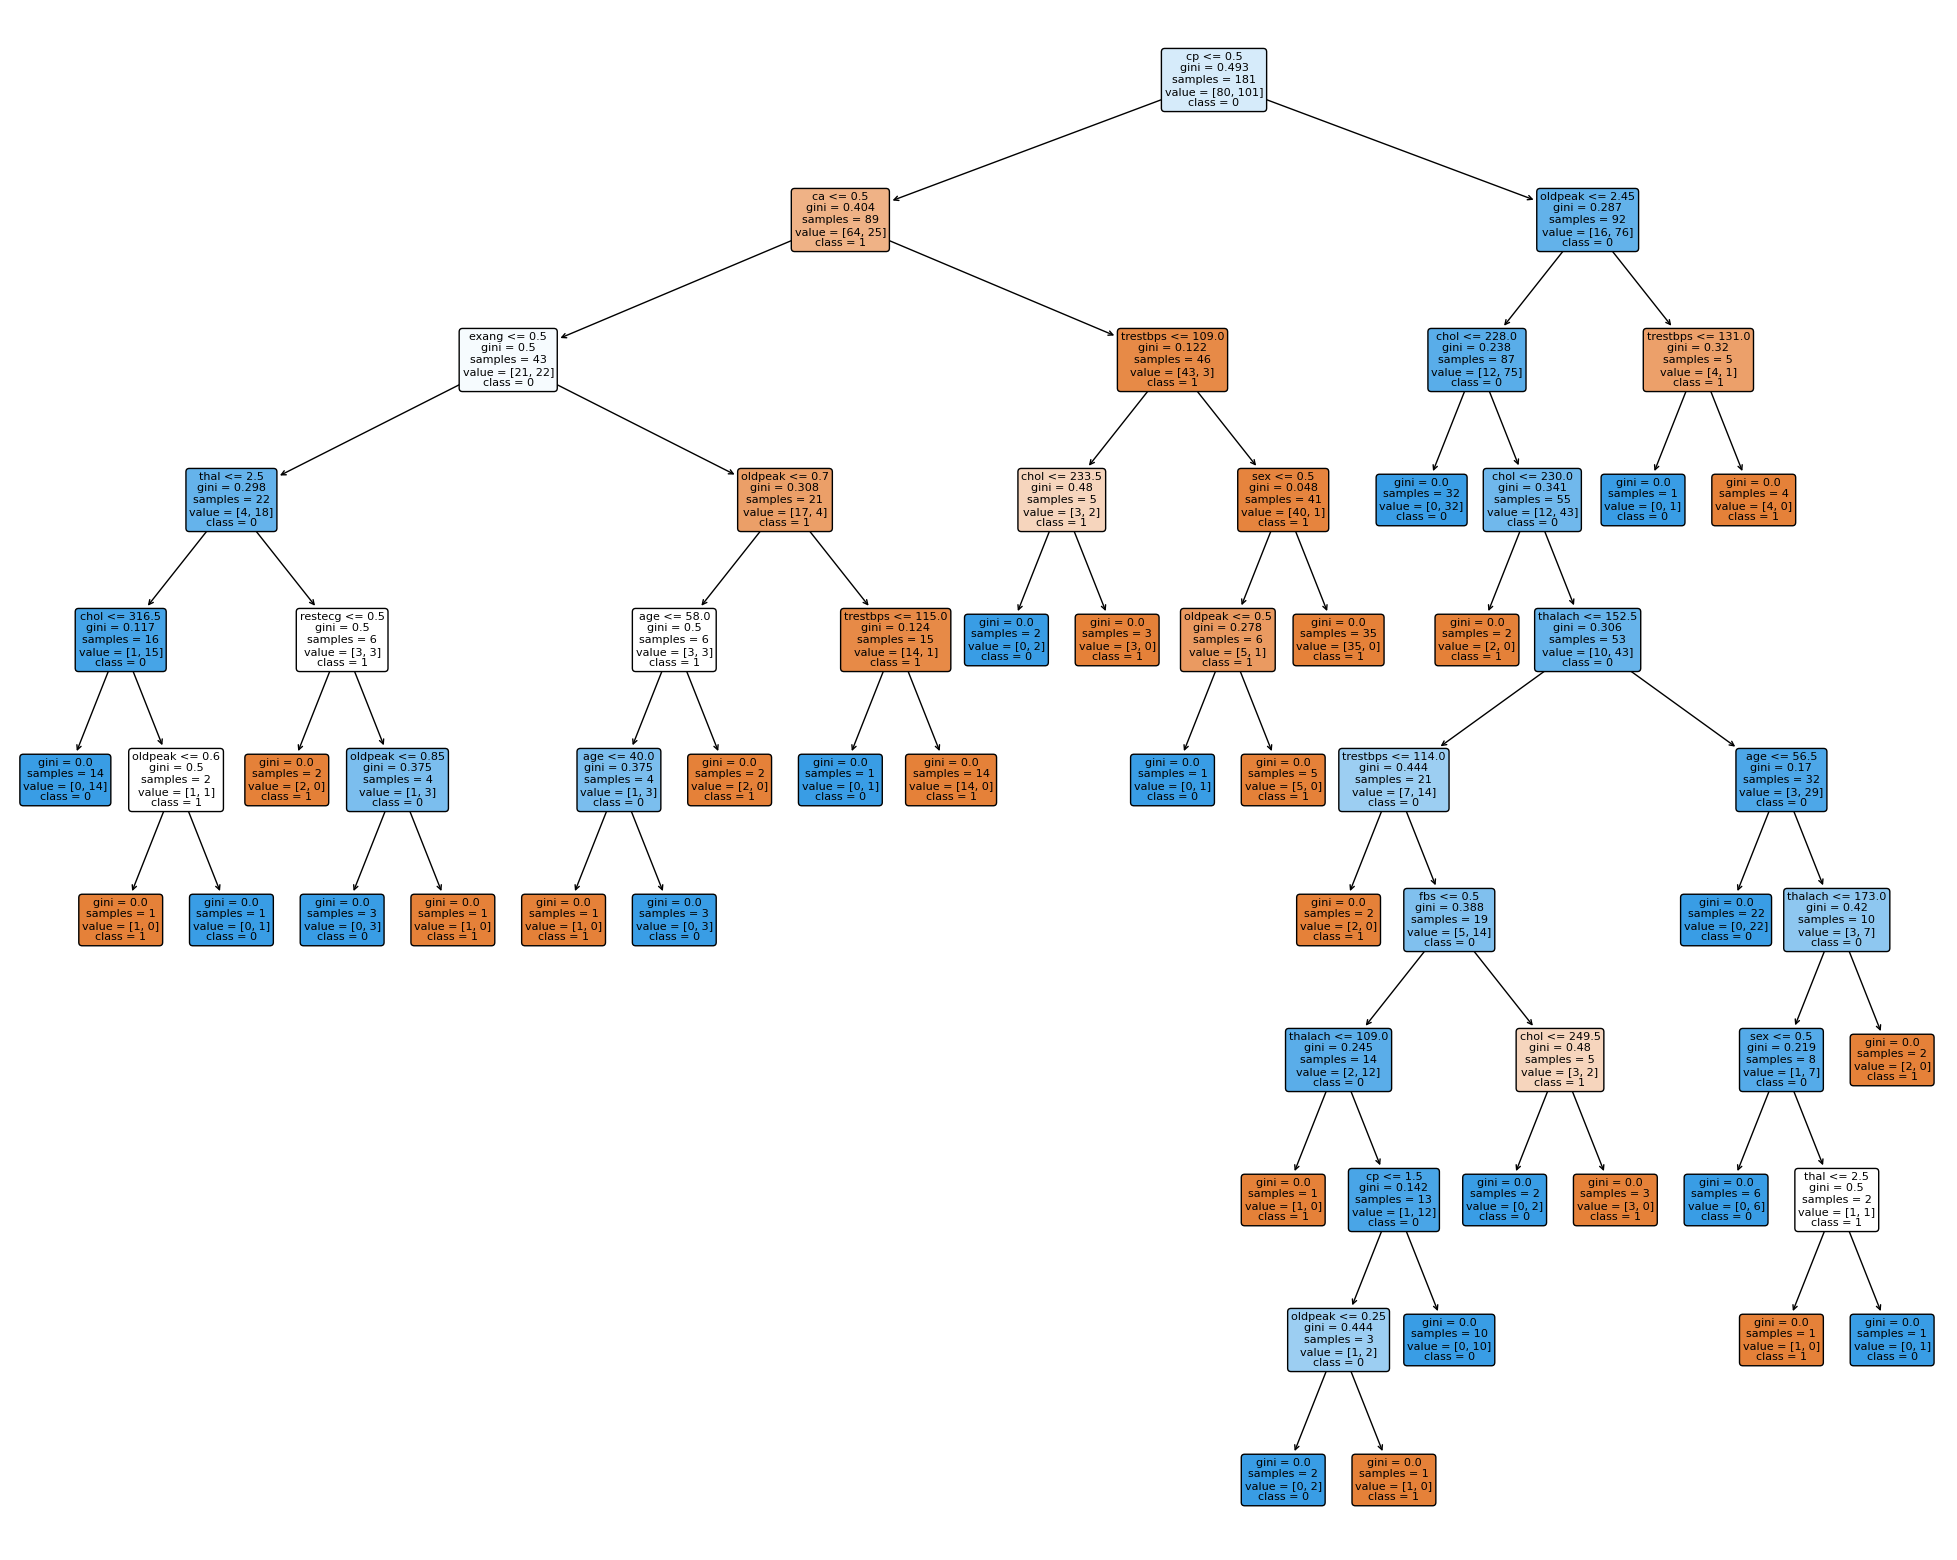

In [163]:
#Plot the tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(full_tree,
              feature_names=features_heart.columns.values,
              class_names=list(map(str, target_heart.unique())),
              rounded=True,
              filled=True)
plt.show()

### Post Pruning

In [164]:
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

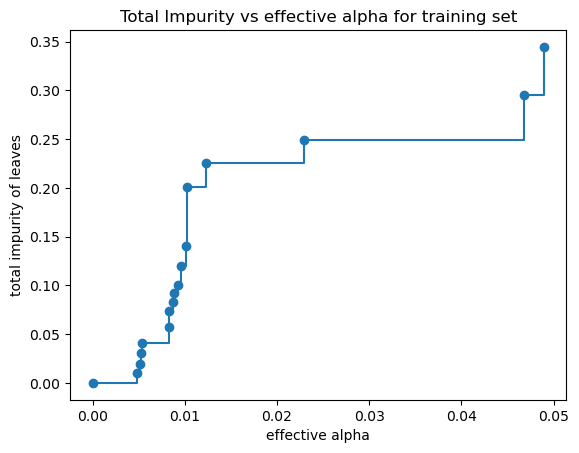

In [165]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [166]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=12345, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.14857419429464191


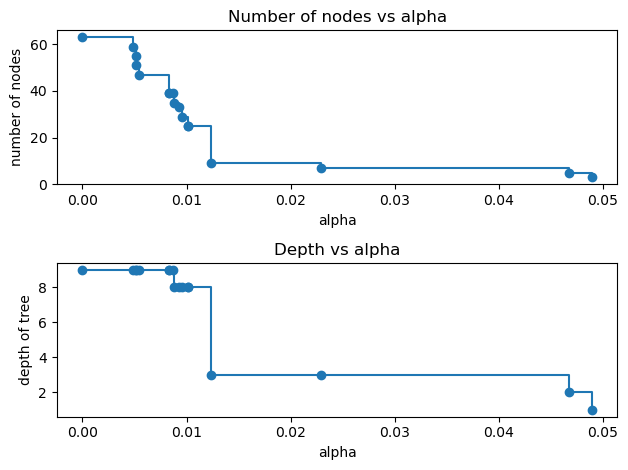

In [167]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

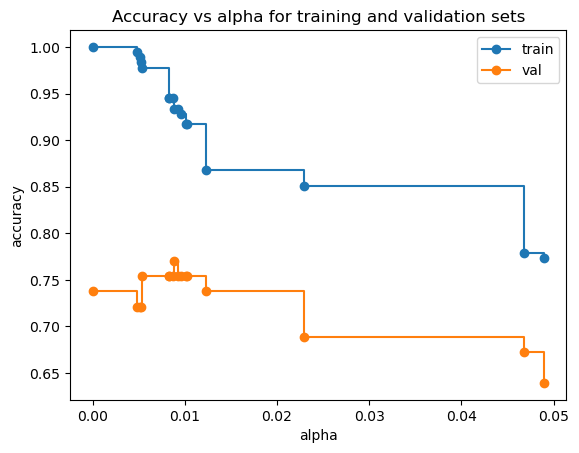

In [168]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="val", drawstyle="steps-post")
ax.legend()
plt.show()

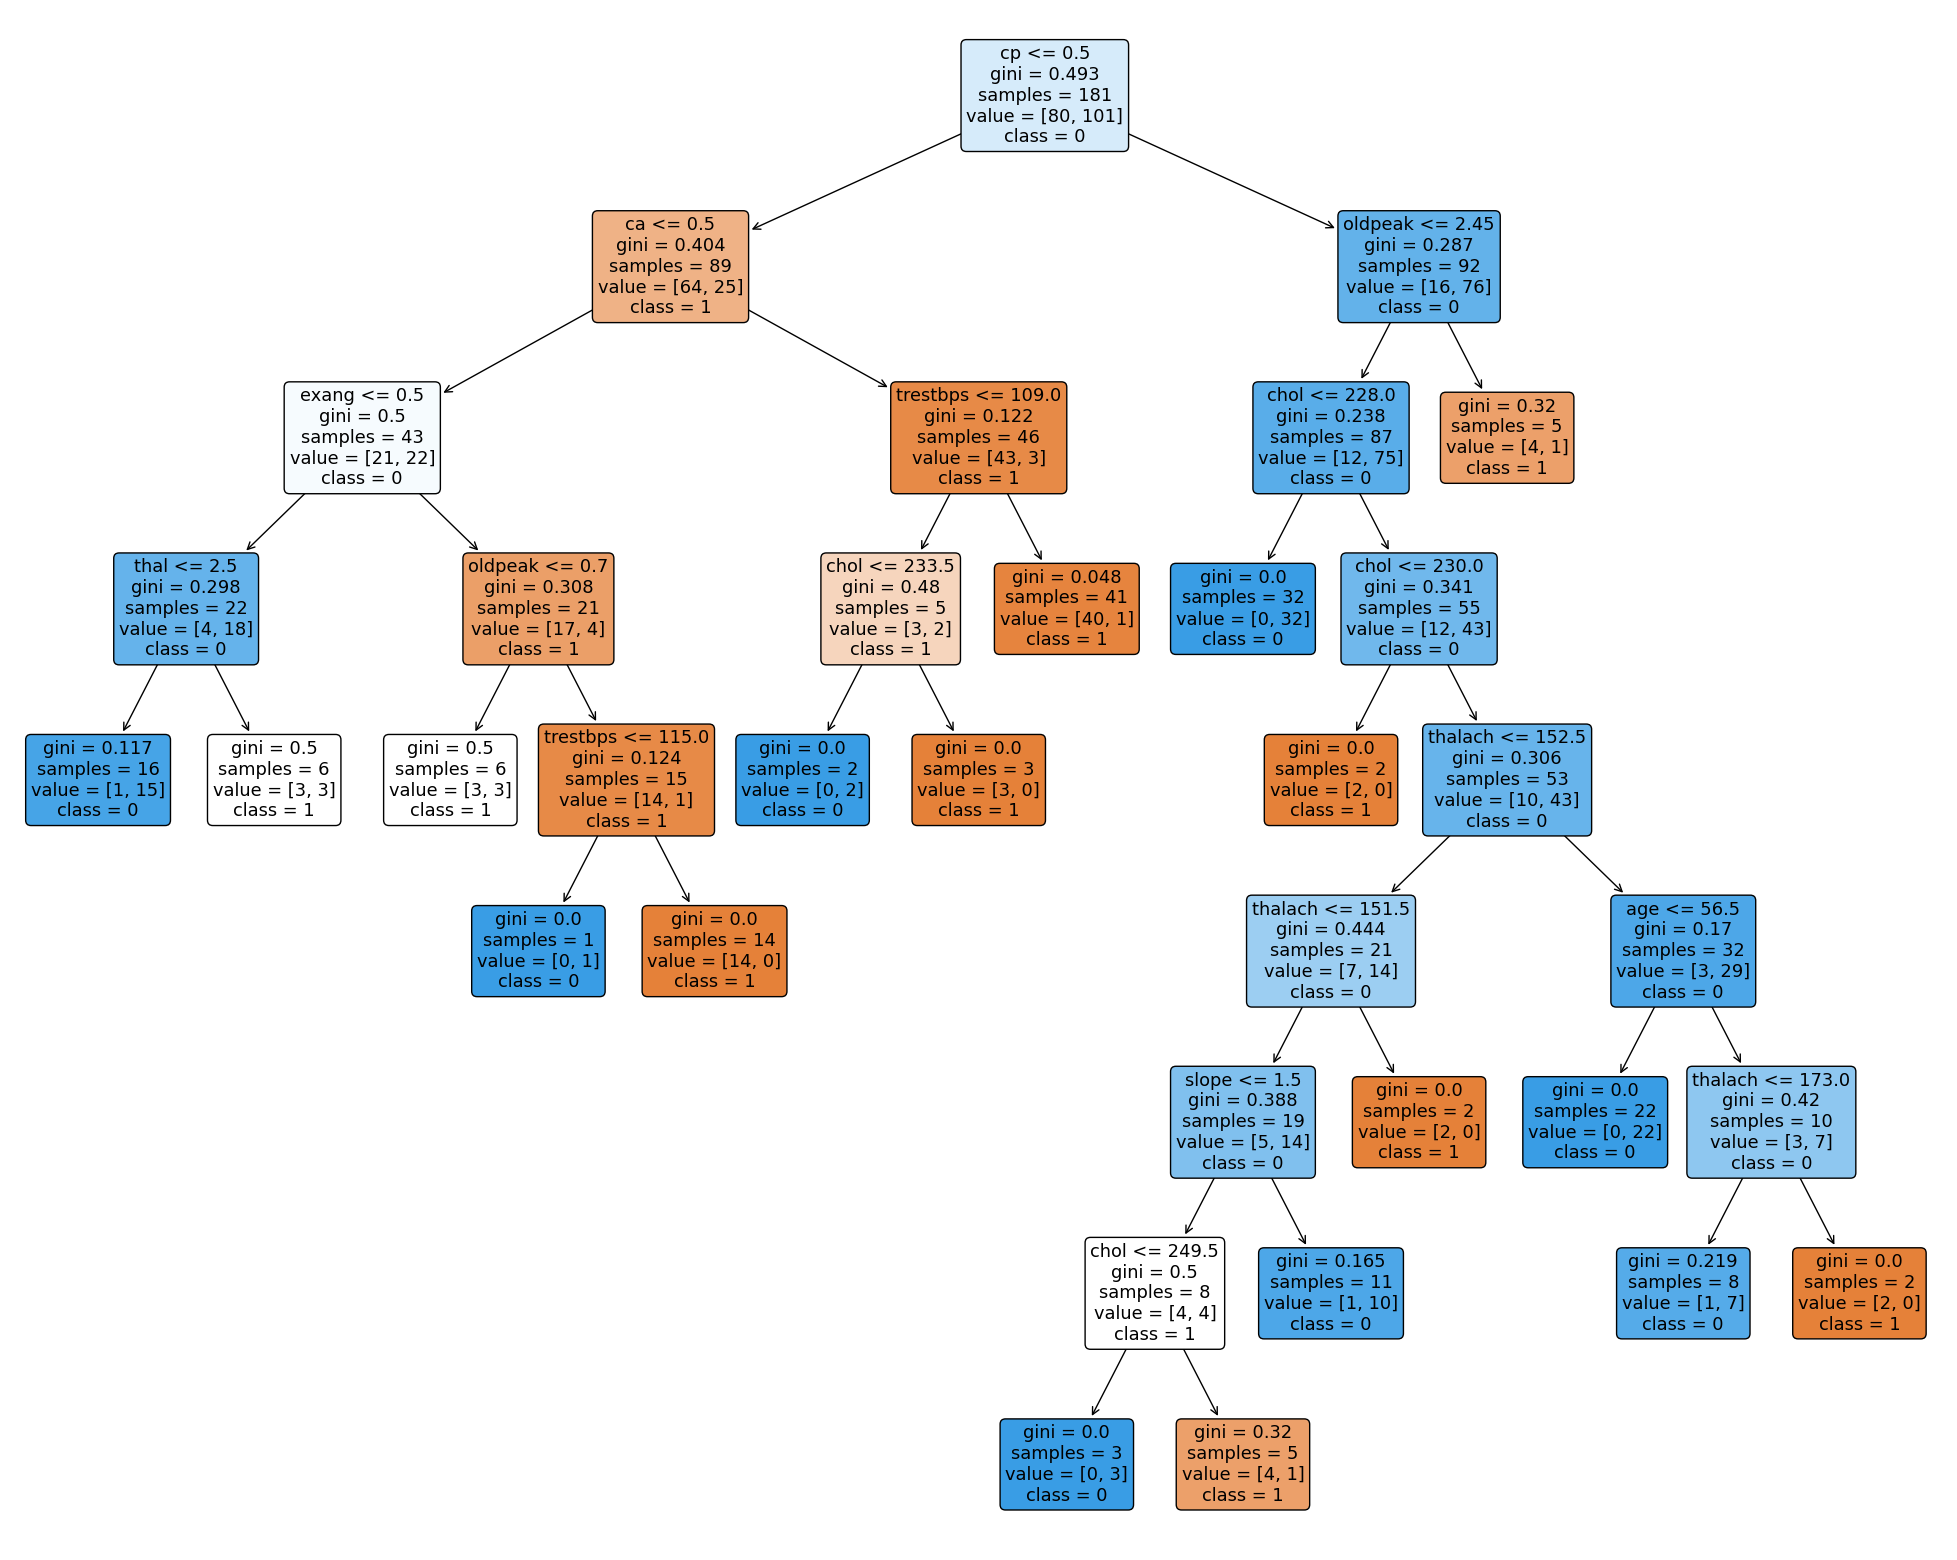

In [169]:
best_clf = clfs[np.argmax(val_scores)]#베스트 스코어 가져오기

fig = plt.figure(figsize=(25,20))
_ = plot_tree(best_clf,
              feature_names=features_heart.columns.values,
              class_names=list(map(str, target_heart.unique())),
              rounded=True,
              filled=True)

In [170]:
CART_post_prey = best_clf.predict(X_val)
Perf_Table.loc['CART_Post_pruning_val'] = perf_eval(y_val, CART_post_prey)
CART_post_prey = best_clf.predict(X_test)
Perf_Table.loc['CART_Post_pruning_test'] = perf_eval(y_test, CART_post_prey)

In [171]:
Perf_Table

TPR  Precision       TNR  Accuracy       BCR  \
CART_Post_pruning_val   0.8750   0.736842  0.655172  0.770492  0.757150   
CART_Post_pruning_test  0.8125   0.866667  0.862069  0.836066  0.836918   

                        F1-Measure     AUROC  
CART_Post_pruning_val      0.80000  0.765086  
CART_Post_pruning_test     0.83871  0.837284

### Prepruning

In [172]:
# Tree parameter settings
param_grid = {'criterion': ['gini', 'entropy','log_loss'],
                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50],
                'min_samples_leaf': [i for i in range(1, 100, 10)],
                'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}

In [173]:
model = DecisionTreeClassifier(random_state=SEED)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, refit=True)

#5fold 방식을 사용하므로, train과 val을 합쳐서 train으로 사용
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

grid_search.fit(X_train_val, y_train_val)

best_criterion = grid_search.best_params_['criterion']
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_max_features = grid_search.best_params_['max_features']

print(f'best criterion: {best_criterion}')
print(f'best max_depth: {best_max_depth}')
print(f'best min_samples_split: {best_min_samples_split}')
print(f'best min_samples_leaf: {best_min_samples_leaf}')
print(f'best max_features: {best_max_features}')


y_pred = grid_search.predict(X_val)
Perf_Table.loc['CART_Pre_pruning_val'] = perf_eval(y_val, y_pred)
y_pred = grid_search.predict(X_test)
Perf_Table.loc['CART_Pre_pruning_test'] = perf_eval(y_test, y_pred)

Perf_Table

best criterion: gini
best max_depth: 4
best min_samples_split: 30
best min_samples_leaf: 11
best max_features: 11


TPR  Precision       TNR  Accuracy       BCR  \
CART_Post_pruning_val   0.8750   0.736842  0.655172  0.770492  0.757150   
CART_Post_pruning_test  0.8125   0.866667  0.862069  0.836066  0.836918   
CART_Pre_pruning_val    0.8125   0.787879  0.758621  0.786885  0.785098   
CART_Pre_pruning_test   0.7500   0.827586  0.827586  0.786885  0.787839   

                        F1-Measure     AUROC  
CART_Post_pruning_val     0.800000  0.765086  
CART_Post_pruning_test    0.838710  0.837284  
CART_Pre_pruning_val      0.800000  0.785560  
CART_Pre_pruning_test     0.786885  0.788793

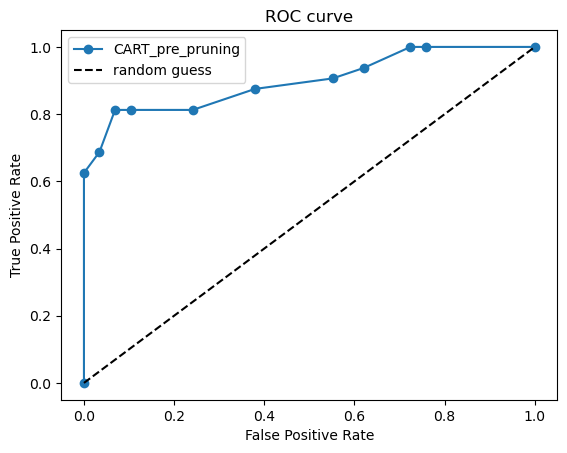

In [174]:
CART_pre_prob = grid_search.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, CART_pre_prob)
plt.plot(fpr, tpr, 'o-', label="CART_pre_pruning")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

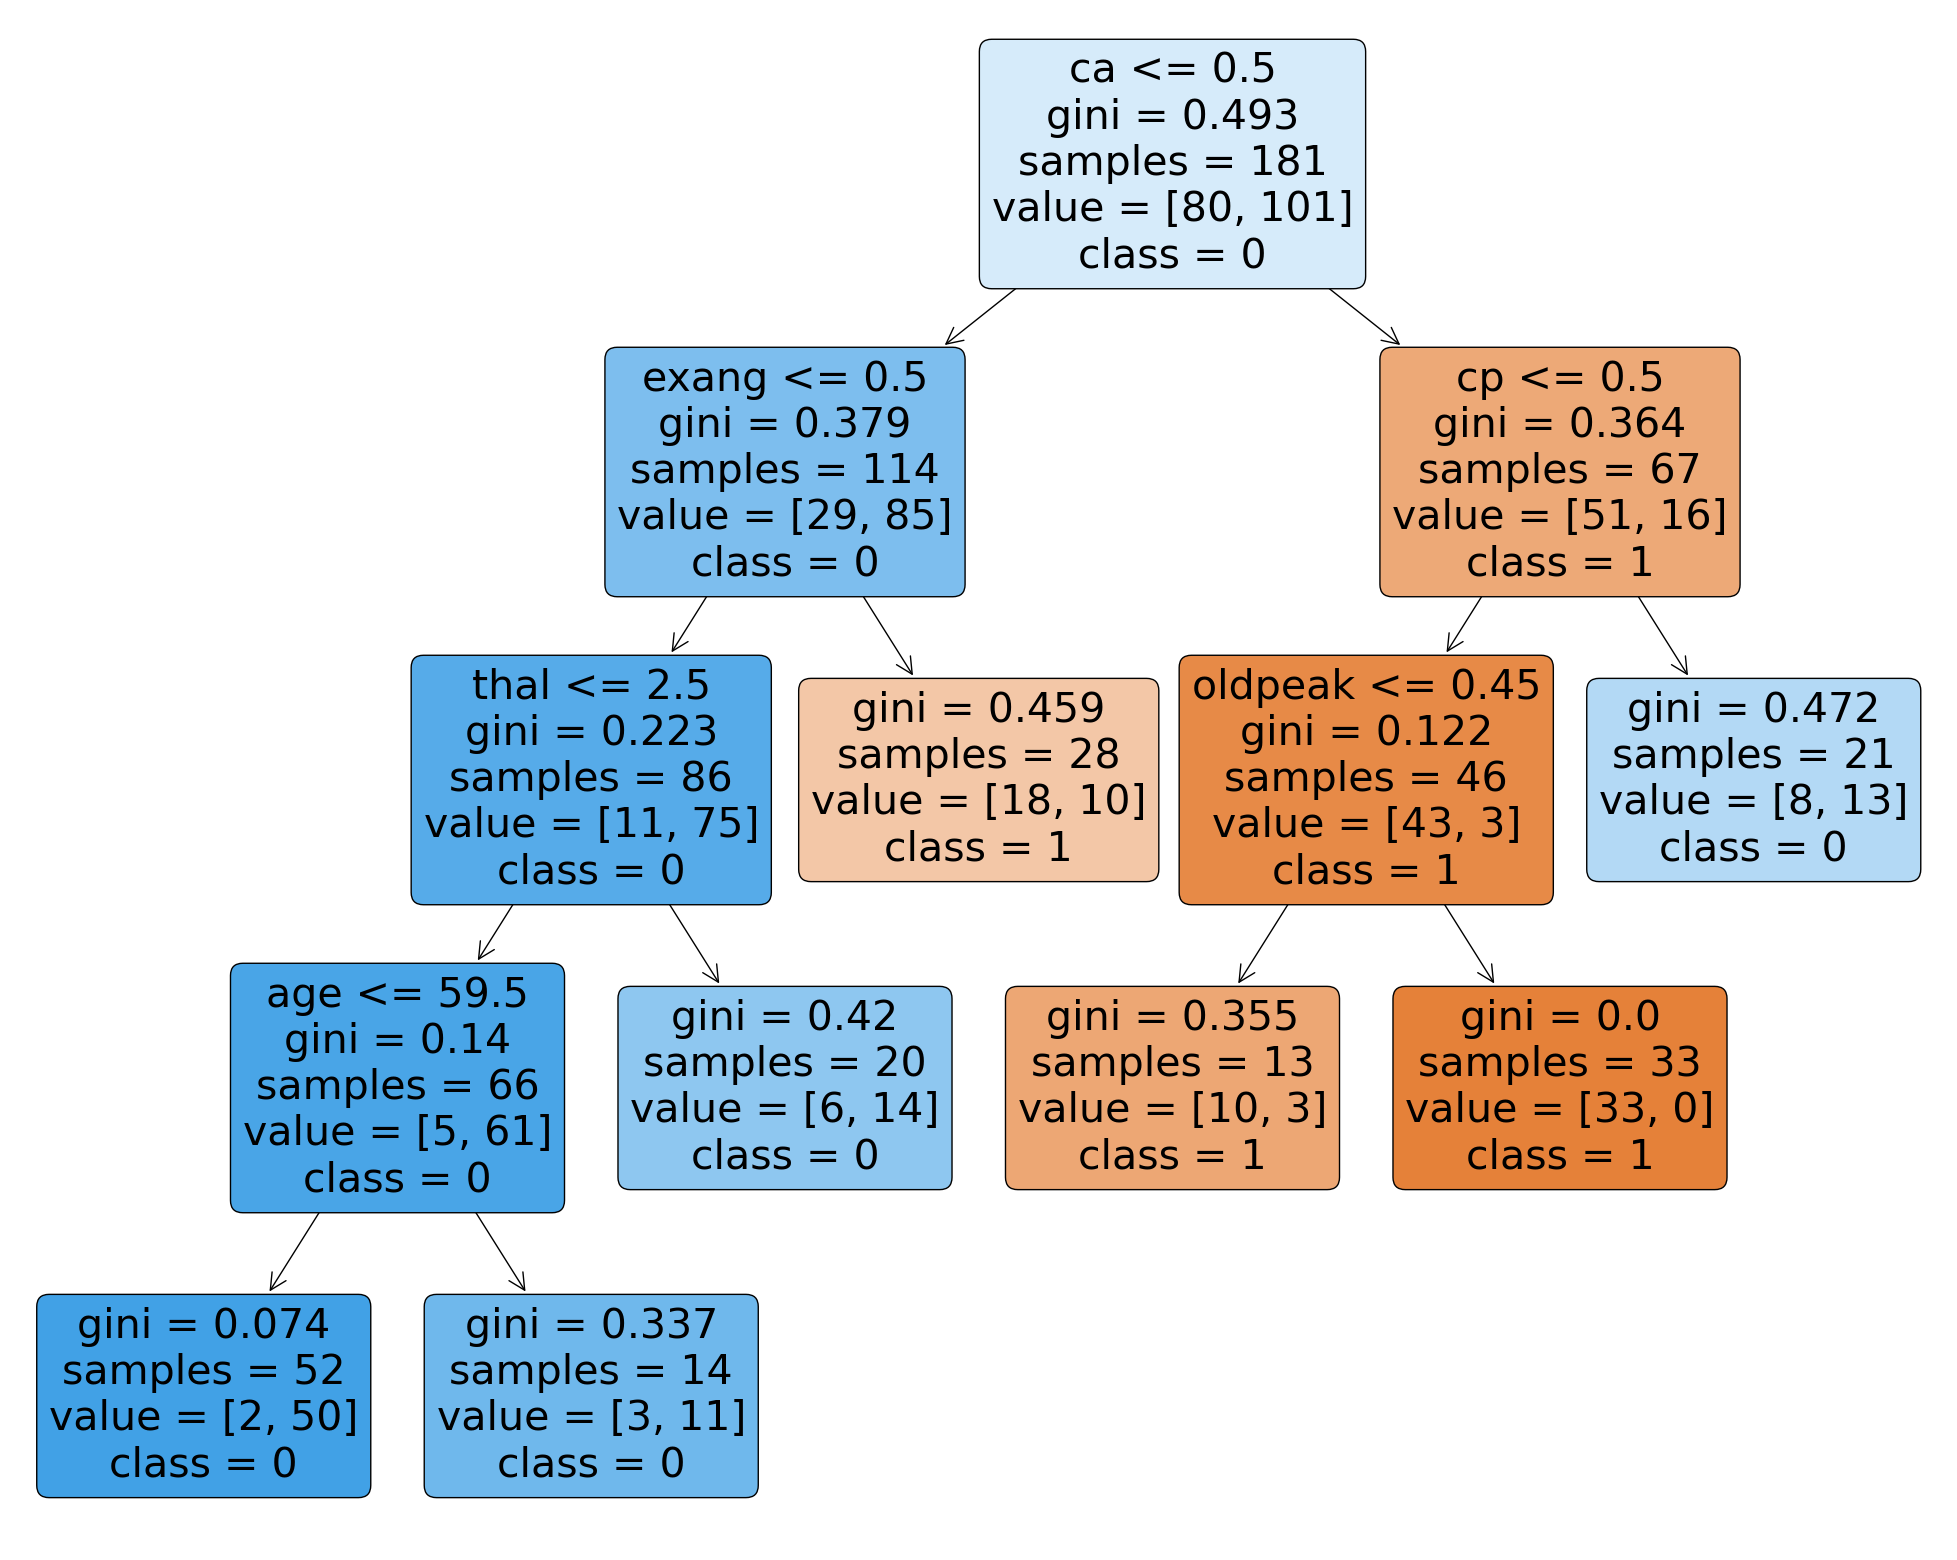

In [175]:
CART_pre = DecisionTreeClassifier(**grid_search.best_params_)
CART_pre.fit(X_train, y_train)
plt.figure(figsize=(25,20))
_ = plot_tree(CART_pre,
                feature_names=features_heart.columns.values,
                class_names=list(map(str, target_heart.unique())),
                rounded=True,
                filled=True)
plt.show()

## Neural Network

In [176]:
def perf_eval_NN(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    # Simple Accuracy
    ACC = np.trace(cm) / np.sum(cm)
    
    # Balanced Correction Rate
    BCR = np.power(np.prod(np.diag(cm) / np.sum(cm, axis=1)), 1/cm.shape[0])
    
    return ACC, BCR

def perf_eval_multi(cm):
# Simple Accuracy
  ACC = np.trace(cm) / np.sum(cm)
  
  # Balanced Correction Rate
  BCR = np.power(np.prod(np.diag(cm) / np.sum(cm, axis=1)), 1/cm.shape[0])
  
  return ACC, BCR

In [177]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

In [178]:
ml_logit = LogisticRegression(random_state=SEED, solver = 'newton-cg')
ml_logit.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42, solver='newton-cg')

In [179]:
print(ml_logit.coef_)

[[-0.01351514 -0.72603801  0.964688   -0.28747984 -0.30612473  0.07188385
   0.31037869  0.60192934 -0.46536314 -0.41992922  0.54671925 -0.92748149
  -0.5017192 ]]


In [180]:
ml_logit_prey = ml_logit.predict(X_val_scaled)
Perf_Table.loc['LogisticRegression_val'] = perf_eval(y_val, ml_logit_prey)
ml_logit_prey = ml_logit.predict(X_test_scaled)
Perf_Table.loc['LogisticRegression_test'] = perf_eval(y_test, ml_logit_prey)

In [181]:
Perf_Table

TPR  Precision       TNR  Accuracy       BCR  \
CART_Post_pruning_val    0.87500   0.736842  0.655172  0.770492  0.757150   
CART_Post_pruning_test   0.81250   0.866667  0.862069  0.836066  0.836918   
CART_Pre_pruning_val     0.81250   0.787879  0.758621  0.786885  0.785098   
CART_Pre_pruning_test    0.75000   0.827586  0.827586  0.786885  0.787839   
LogisticRegression_val   0.84375   0.794118  0.758621  0.803279  0.800054   
LogisticRegression_test  0.84375   0.870968  0.862069  0.852459  0.852860   

                         F1-Measure     AUROC  
CART_Post_pruning_val      0.800000  0.765086  
CART_Post_pruning_test     0.838710  0.837284  
CART_Pre_pruning_val       0.800000  0.785560  
CART_Pre_pruning_test      0.786885  0.788793  
LogisticRegression_val     0.818182  0.801185  
LogisticRegression_test    0.857143  0.852909

#### NN

In [182]:
target_heart.unique()

array([1, 0], dtype=int64)

In [183]:
ann_trn_input = X_train_scaled
ann_trn_target = y_train
ann_val_input = X_val_scaled
ann_val_target = y_val
ann_tst_input = X_test_scaled
ann_tst_target = y_test

In [184]:
hyperparameters = {
    'hidden_layer_sizes' : [(10,), (20,), (30,),(40,), (50,)
                            ,(10,10), (20,20), (30,30), (40,40), (50,50)
                            ,(10,10,10), (20,20,20), (30,30,30), (40,40,40), (50,50,50)],
    
    'activation_functions' : ['logistic', 'tanh', 'relu']
}

k fold를 사용하려 했으나, 데이터 수 부족으로 불가능.

In [212]:
# Find the best number of hidden nodes in terms of BCR
# Candidate hidden nodes

val_perf = pd.DataFrame(columns = ["TPR", "Precision", "TNR", "Accuracy", "BCR", "F1-Measure", "AUROC"])

best_model = None
for nh in hyperparameters['hidden_layer_sizes']:
    for act in hyperparameters['activation_functions']:
        print(f'hidden nodes: {nh}, activation function: {act}')
        
        tmp_nnet = MLPClassifier(hidden_layer_sizes= nh, activation=act, max_iter=500, verbose=True)
        tmp_nnet.fit(ann_trn_input, ann_trn_target)
        
        y_pred = tmp_nnet.predict(ann_val_input)
        val_perf.loc[f'hidden nodes: {nh}, activation function: {act}'] = perf_eval(ann_val_target, y_pred)
        if best_model is None:
            best_model = tmp_nnet
        elif roc_auc_score(ann_val_target, y_pred) > roc_auc_score(ann_val_target, best_model.predict(ann_val_input)):
            best_model = tmp_nnet
        
val_perf

hidden nodes: (10,), activation function: logistic
Iteration 1, loss = 0.71892243
Iteration 2, loss = 0.71702449
Iteration 3, loss = 0.71514284
Iteration 4, loss = 0.71327777
Iteration 5, loss = 0.71142958
Iteration 6, loss = 0.70959853
Iteration 7, loss = 0.70778487
Iteration 8, loss = 0.70598884
Iteration 9, loss = 0.70421065
Iteration 10, loss = 0.70245051
Iteration 11, loss = 0.70070859
Iteration 12, loss = 0.69898504
Iteration 13, loss = 0.69728002
Iteration 14, loss = 0.69559364
Iteration 15, loss = 0.69392599
Iteration 16, loss = 0.69227715
Iteration 17, loss = 0.69064718
Iteration 18, loss = 0.68903610
Iteration 19, loss = 0.68744393
Iteration 20, loss = 0.68587066
Iteration 21, loss = 0.68431625
Iteration 22, loss = 0.68278066
Iteration 23, loss = 0.68126379
Iteration 24, loss = 0.67976558
Iteration 25, loss = 0.67828589
Iteration 26, loss = 0.67682459
Iteration 27, loss = 0.67538155
Iteration 28, loss = 0.67395657
Iteration 29, loss = 0.67254948
Iteration 30, loss = 0.6711600

TPR  Precision  \
hidden nodes: (10,), activation function: logistic  0.87500   0.823529   
hidden nodes: (10,), activation function: tanh      0.81250   0.838710   
hidden nodes: (10,), activation function: relu      0.81250   0.812500   
hidden nodes: (20,), activation function: logistic  0.87500   0.823529   
hidden nodes: (20,), activation function: tanh      0.81250   0.812500   
hidden nodes: (20,), activation function: relu      0.78125   0.757576   
hidden nodes: (30,), activation function: logistic  0.87500   0.800000   
hidden nodes: (30,), activation function: tanh      0.81250   0.787879   
hidden nodes: (30,), activation function: relu      0.78125   0.781250   
hidden nodes: (40,), activation function: logistic  0.87500   0.800000   
hidden nodes: (40,), activation function: tanh      0.78125   0.833333   
hidden nodes: (40,), activation function: relu      0.81250   0.787879   
hidden nodes: (50,), activation function: logistic  0.87500   0.800000   
hidden nodes: (50,), activation function: tanh      0.81250   0.838710   
hidden nodes: (50,), activation function: relu      0.78125   0.781250   
hidden nodes: (10, 10), activation function: lo...  0.87500   0.823529   
hidden nodes: (10, 10), activation function: tanh   0.81250   0.812500   
hidden nodes: (10, 10), activation function: relu   0.75000   0.827586   
hidden nodes: (20, 20), activation function: lo...  0.81250   0.812500   
hidden nodes: (20, 20), activation function: tanh   0.84375   0.818182   
hidden nodes: (20, 20), activation function: relu   0.78125   0.757576   
hidden nodes: (30, 30), activation function: lo...  0.84375   0.843750   
hidden nodes: (30, 30), activation function: tanh   0.71875   0.821429   
hidden nodes: (30, 30), activation function: relu   0.78125   0.781250   
hidden nodes: (40, 40), activation function: lo...  0.84375   0.843750   
hidden nodes: (40, 40), activation function: tanh   0.78125   0.735294   
hidden nodes: (40, 40), activation function: relu   0.75000   0.750000   
hidden nodes: (50, 50), activation function: lo...  0.84375   0.794118   
hidden nodes: (50, 50), activation function: tanh   0.75000   0.800000   
hidden nodes: (50, 50), activation function: relu   0.75000   0.800000   
hidden nodes: (10, 10, 10), activation function...  1.00000   0.524590   
hidden nodes: (10, 10, 10), activation function...  0.87500   0.823529   
hidden nodes: (10, 10, 10), activation function...  0.84375   0.750000   
hidden nodes: (20, 20, 20), activation function...  0.87500   0.848485   
hidden nodes: (20, 20, 20), activation function...  0.75000   0.800000   
hidden nodes: (20, 20, 20), activation function...  0.75000   0.705882   
hidden nodes: (30, 30, 30), activation function...  1.00000   0.524590   
hidden nodes: (30, 30, 30), activation function...  0.81250   0.742857   
hidden nodes: (30, 30, 30), activation function...  0.78125   0.833333   
hidden nodes: (40, 40, 40), activation function...  0.81250   0.812500   
hidden nodes: (40, 40, 40), activation function...  0.75000   0.800000   
hidden nodes: (40, 40, 40), activation function...  0.78125   0.781250   
hidden nodes: (50, 50, 50), activation function...  0.81250   0.787879   
hidden nodes: (50, 50, 50), activation function...  0.81250   0.764706   
hidden nodes: (50, 50, 50), activation function...  0.78125   0.781250   

                                                         TNR  Accuracy  \
hidden nodes: (10,), activation function: logistic  0.793103  0.836066   
hidden nodes: (10,), activation function: tanh      0.827586  0.819672   
hidden nodes: (10,), activation function: relu      0.793103  0.803279   
hidden nodes: (20,), activation function: logistic  0.793103  0.836066   
hidden nodes: (20,), activation function: tanh      0.793103  0.803279   
hidden nodes: (20,), activation function: relu      0.724138  0.754098   
hidden nodes: (30,), activation function: logistic  0.758621  0.819672   
hidden nodes: (30,), activation function: tanh      0.75862

In [213]:
ordered_val_perf = val_perf.sort_values(by='AUROC', ascending=False)
ordered_val_perf

TPR  Precision  \
hidden nodes: (20, 20, 20), activation function...  0.87500   0.848485   
hidden nodes: (40, 40), activation function: lo...  0.84375   0.843750   
hidden nodes: (30, 30), activation function: lo...  0.84375   0.843750   
hidden nodes: (10, 10), activation function: lo...  0.87500   0.823529   
hidden nodes: (10, 10, 10), activation function...  0.87500   0.823529   
hidden nodes: (10,), activation function: logistic  0.87500   0.823529   
hidden nodes: (20,), activation function: logistic  0.87500   0.823529   
hidden nodes: (50,), activation function: tanh      0.81250   0.838710   
hidden nodes: (10,), activation function: tanh      0.81250   0.838710   
hidden nodes: (20, 20), activation function: tanh   0.84375   0.818182   
hidden nodes: (30,), activation function: logistic  0.87500   0.800000   
hidden nodes: (50,), activation function: logistic  0.87500   0.800000   
hidden nodes: (40,), activation function: logistic  0.87500   0.800000   
hidden nodes: (30, 30, 30), activation function...  0.78125   0.833333   
hidden nodes: (40,), activation function: tanh      0.78125   0.833333   
hidden nodes: (10, 10), activation function: tanh   0.81250   0.812500   
hidden nodes: (20, 20), activation function: lo...  0.81250   0.812500   
hidden nodes: (20,), activation function: tanh      0.81250   0.812500   
hidden nodes: (40, 40, 40), activation function...  0.81250   0.812500   
hidden nodes: (10,), activation function: relu      0.81250   0.812500   
hidden nodes: (50, 50), activation function: lo...  0.84375   0.794118   
hidden nodes: (10, 10), activation function: relu   0.75000   0.827586   
hidden nodes: (40,), activation function: relu      0.81250   0.787879   
hidden nodes: (30,), activation function: tanh      0.81250   0.787879   
hidden nodes: (50, 50, 50), activation function...  0.81250   0.787879   
hidden nodes: (30, 30), activation function: tanh   0.71875   0.821429   
hidden nodes: (40, 40, 40), activation function...  0.75000   0.800000   
hidden nodes: (50, 50), activation function: tanh   0.75000   0.800000   
hidden nodes: (50, 50), activation function: relu   0.75000   0.800000   
hidden nodes: (20, 20, 20), activation function...  0.75000   0.800000   
hidden nodes: (50, 50, 50), activation function...  0.78125   0.781250   
hidden nodes: (30, 30), activation function: relu   0.78125   0.781250   
hidden nodes: (40, 40, 40), activation function...  0.78125   0.781250   
hidden nodes: (50,), activation function: relu      0.78125   0.781250   
hidden nodes: (30,), activation function: relu      0.78125   0.781250   
hidden nodes: (50, 50, 50), activation function...  0.81250   0.764706   
hidden nodes: (10, 10, 10), activation function...  0.84375   0.750000   
hidden nodes: (20, 20), activation function: relu   0.78125   0.757576   
hidden nodes: (20,), activation function: relu      0.78125   0.757576   
hidden nodes: (30, 30, 30), activation function...  0.81250   0.742857   
hidden nodes: (40, 40), activation function: relu   0.75000   0.750000   
hidden nodes: (40, 40), activation function: tanh   0.78125   0.735294   
hidden nodes: (20, 20, 20), activation function...  0.75000   0.705882   
hidden nodes: (30, 30, 30), activation function...  1.00000   0.524590   
hidden nodes: (10, 10, 10), activation function...  1.00000   0.524590   

                                                         TNR  Accuracy  \
hidden nodes: (20, 20, 20), activation function...  0.827586  0.852459   
hidden nodes: (40, 40), activation function: lo...  0.827586  0.836066   
hidden nodes: (30, 30), activation function: lo...  0.827586  0.836066   
hidden nodes: (10, 10), activation function: lo...  0.793103  0.836066   
hidden nodes: (10, 10, 10), activation function...  0.793103  0.836066   
hidden nodes: (10,), activation function: logistic  0.793103  0.836066   
hidden nodes: (20,), activation function: logistic  0.793103  0.836066   
hidden nodes: (50,), activation function: tanh      0.82758

In [214]:
hidden_act = pd.DataFrame(np.array(val_perf.iloc[:, 6]).reshape(15,3), columns = ['logistic', 'tanh', 'relu'], index = 
             [(10,), (20,), (30,),(40,), (50,),
              (10,10), (20,20), (30,30), (40,40), (50,50),
                (10,10,10), (20,20,20), (30,30,30), (40,40,40), (50,50,50)])
              
hidden_act

logistic      tanh      relu
(10,)         0.834052  0.820043  0.802802
(20,)         0.834052  0.802802  0.752694
(30,)         0.816810  0.785560  0.769935
(40,)         0.816810  0.804418  0.785560
(50,)         0.816810  0.820043  0.769935
(10, 10)      0.834052  0.802802  0.788793
(20, 20)      0.802802  0.818427  0.752694
(30, 30)      0.835668  0.773168  0.769935
(40, 40)      0.835668  0.735453  0.737069
(50, 50)      0.801185  0.771552  0.771552
(10, 10, 10)  0.500000  0.834052  0.766703
(20, 20, 20)  0.851293  0.771552  0.702586
(30, 30, 30)  0.500000  0.751078  0.804418
(40, 40, 40)  0.802802  0.771552  0.769935
(50, 50, 50)  0.785560  0.768319  0.769935

In [215]:
best_model

MLPClassifier(activation='logistic', hidden_layer_sizes=(20, 20, 20),
              max_iter=500, verbose=True)

In [220]:
# Best model
y_pred = best_model.predict(ann_val_input)
Perf_Table.loc['NN_val'] = perf_eval(ann_val_target, y_pred)
y_pred = best_model.predict(ann_tst_input)
Perf_Table.loc['NN_test'] = perf_eval(ann_tst_target, y_pred)

In [226]:
Perf_Table

TPR  Precision       TNR  Accuracy       BCR  \
CART_Post_pruning_val    0.87500   0.736842  0.655172  0.770492  0.757150   
CART_Post_pruning_test   0.81250   0.866667  0.862069  0.836066  0.836918   
CART_Pre_pruning_val     0.81250   0.787879  0.758621  0.786885  0.785098   
CART_Pre_pruning_test    0.75000   0.827586  0.827586  0.786885  0.787839   
LogisticRegression_val   0.84375   0.794118  0.758621  0.803279  0.800054   
LogisticRegression_test  0.84375   0.870968  0.862069  0.852459  0.852860   
NN_val                   0.87500   0.848485  0.827586  0.852459  0.850963   
NN_test                  0.84375   0.870968  0.862069  0.852459  0.852860   

                         F1-Measure     AUROC  
CART_Post_pruning_val      0.800000  0.765086  
CART_Post_pruning_test     0.838710  0.837284  
CART_Pre_pruning_val       0.800000  0.785560  
CART_Pre_pruning_test      0.786885  0.788793  
LogisticRegression_val     0.818182  0.801185  
LogisticRegression_test    0.857143  0.852909  
NN_val                     0.861538  0.851293  
NN_test                    0.857143  0.852909

In [227]:
def round_dataframe(df, decimals=4):
    rounded_df = df.round(decimals)
    return rounded_df

Perf_Table_Test = round_dataframe(Perf_Table.iloc[[1,3,5,7]])

In [228]:
Perf_Table_Test

TPR  Precision     TNR  Accuracy     BCR  \
CART_Post_pruning_test   0.8125     0.8667  0.8621    0.8361  0.8369   
CART_Pre_pruning_test    0.7500     0.8276  0.8276    0.7869  0.7878   
LogisticRegression_test  0.8438     0.8710  0.8621    0.8525  0.8529   
NN_test                  0.8438     0.8710  0.8621    0.8525  0.8529   

                         F1-Measure   AUROC  
CART_Post_pruning_test       0.8387  0.8373  
CART_Pre_pruning_test        0.7869  0.7888  
LogisticRegression_test      0.8571  0.8529  
NN_test                      0.8571  0.8529

# Wine Quality Dataset

In [266]:
wine = pd.read_csv('wine.csv')

In [267]:
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol quality  
0      9.4     bad  
1      9.8     bad  
2      9.8     bad  
3      9.8    good  
4      9.4     bad

In [268]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


In [270]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
wine['quality'] = le.fit_transform(wine['quality'])

wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        0  
1      9.8        0  
2      9.8        0  
3      9.8        1  
4      9.4        0

In [271]:
data_explanation(wine, 'wine')
features_wine = wine.drop('quality', axis=1)
target_wine = wine['quality']

In [273]:
target_wine #0 : bad, 1: good

0       0
1       0
2       0
3       1
4       0
       ..
1594    0
1595    1
1596    1
1597    0
1598    1
Name: quality, Length: 1599, dtype: int32

In [275]:
Perf_Table_Wine = pd.DataFrame(columns = ["TPR", "Precision", "TNR",
                                            "Accuracy", "BCR", "F1-Measure", "AUROC"])

Perf_Table_Wine

Empty DataFrame
Columns: [TPR, Precision, TNR, Accuracy, BCR, F1-Measure, AUROC]
Index: []

## Decision Tree

### Full Tree

In [277]:
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(features_wine, target_wine,
                                                    test_size=0.2, random_state=SEED)
X_train_wine, X_val_wine, y_train_wine, y_val_wine = train_test_split(X_train_wine, y_train_wine,
                                                    test_size=320, random_state=SEED)

print(len(X_train_wine), len(X_val_wine), len(X_test_wine))

959 320 320


In [278]:
full_tree_wine = DecisionTreeClassifier(random_state=SEED)
full_tree_wine.fit(X_train_wine, y_train_wine)

DecisionTreeClassifier(random_state=42)

In [279]:
full_tree_wine.score(X_train_wine, y_train_wine)

1.0

In [280]:
full_tree_wine.score(X_val_wine, y_val_wine)

0.746875

In [281]:
full_tree_wine.score(X_test_wine, y_test_wine)

0.721875

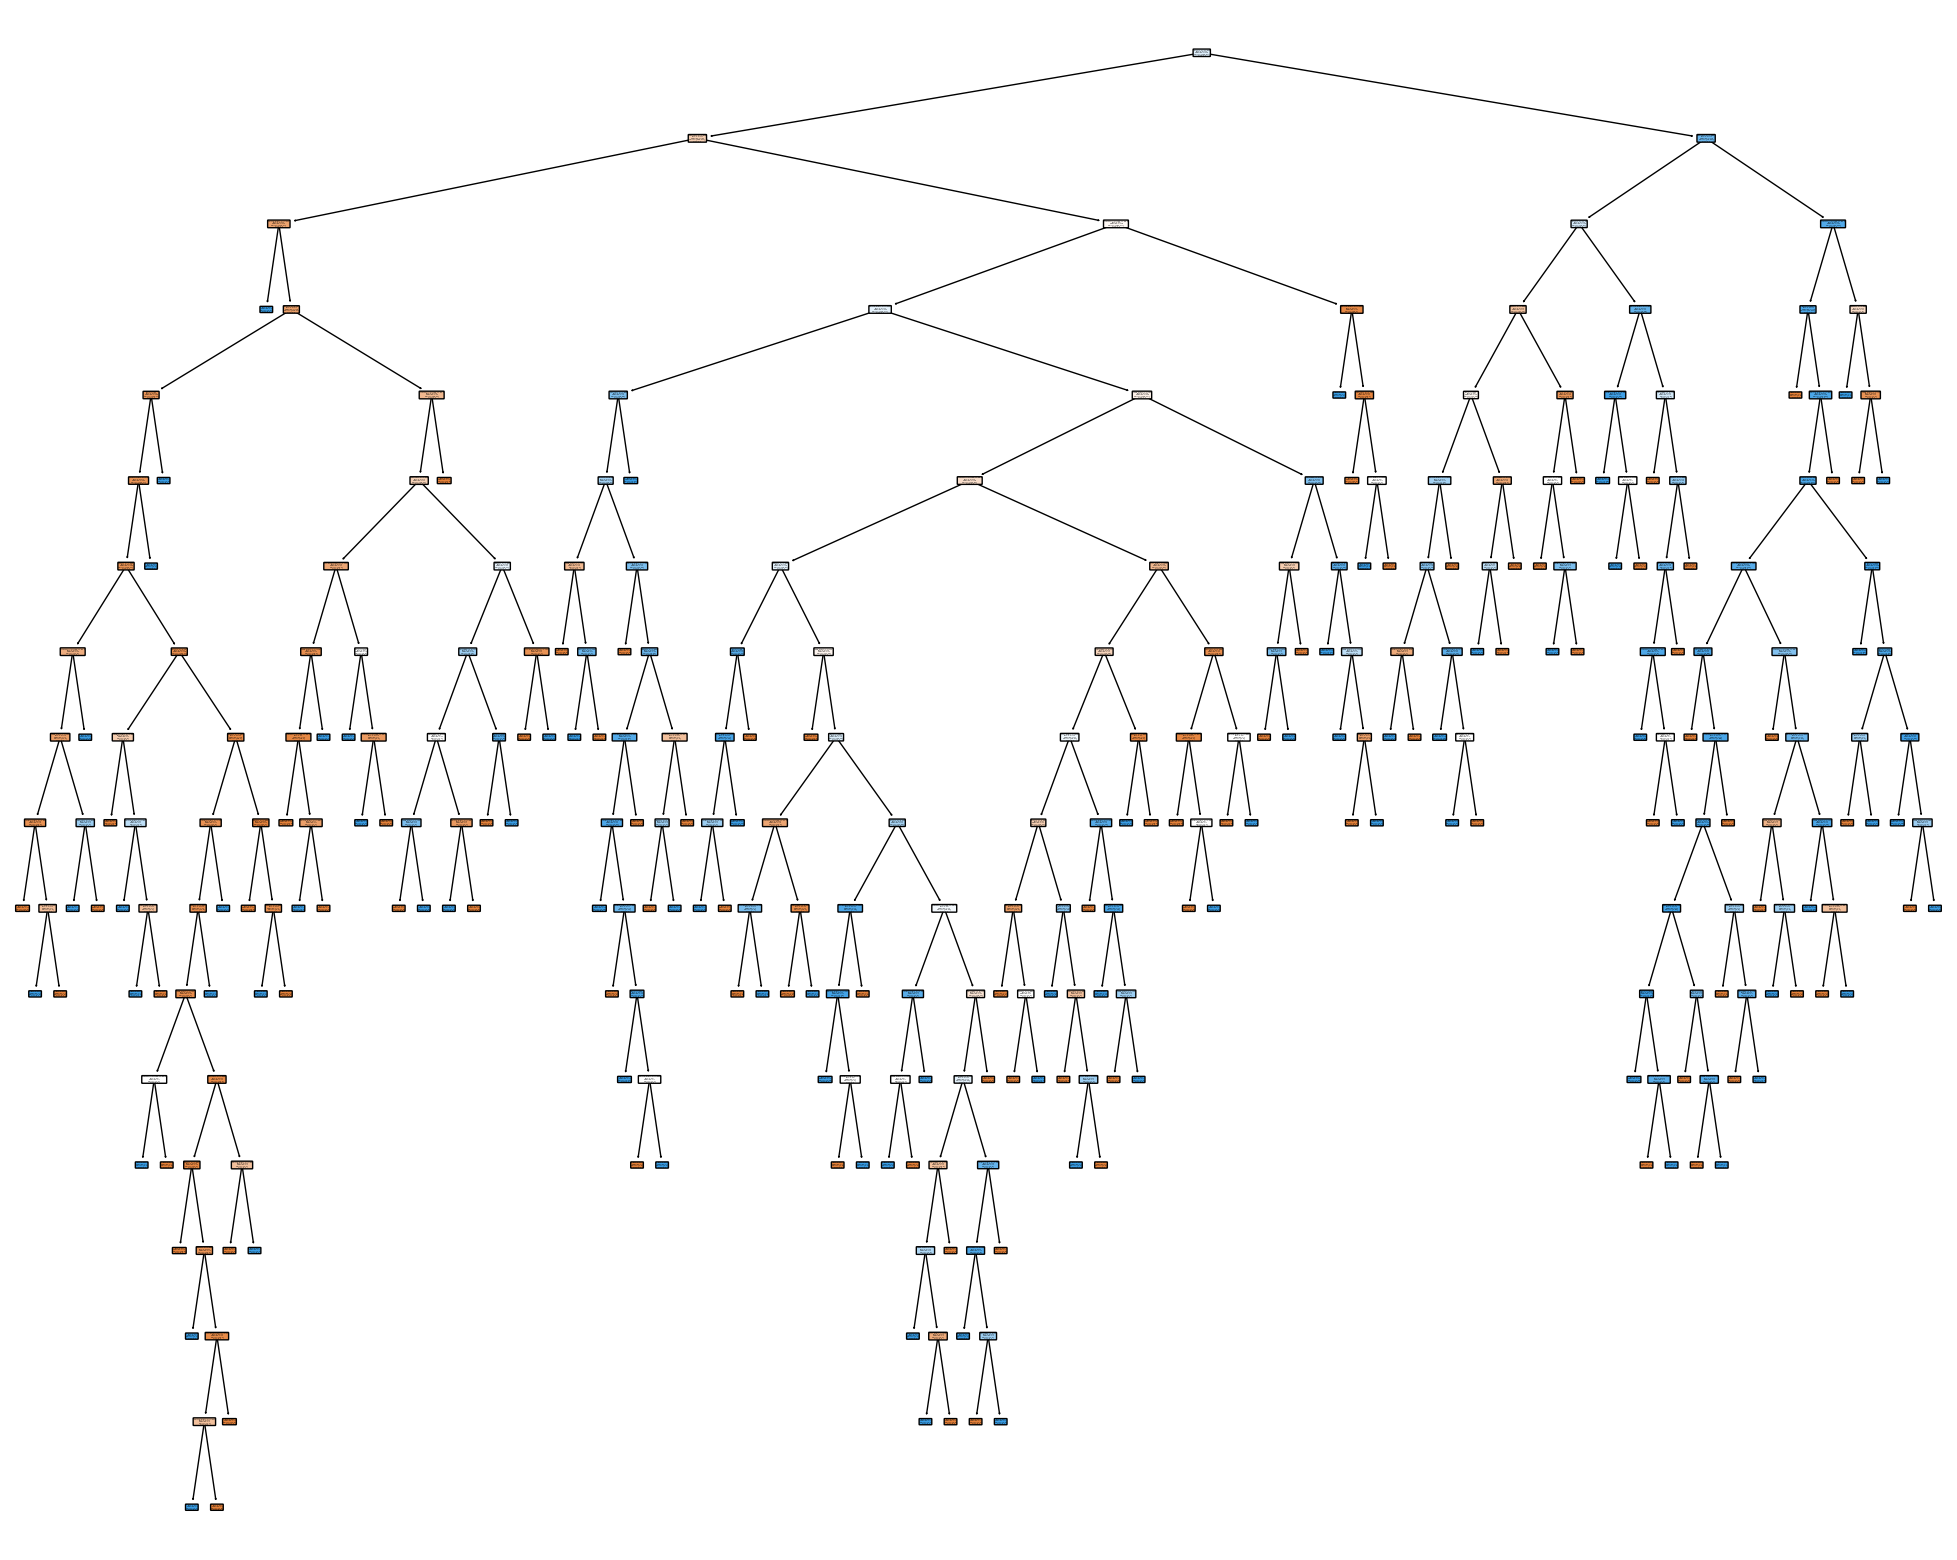

In [282]:
#Plot the tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(full_tree_wine,
                feature_names=features_wine.columns.values,
                class_names=list(map(str, target_wine.unique())),
                rounded=True,
                filled=True)
plt.show()

Post Pruning

In [283]:
path_wine = full_tree_wine.cost_complexity_pruning_path(X_train_wine, y_train_wine)
ccp_alphas_wine, impurities_wine = path_wine.ccp_alphas, path_wine.impurities 

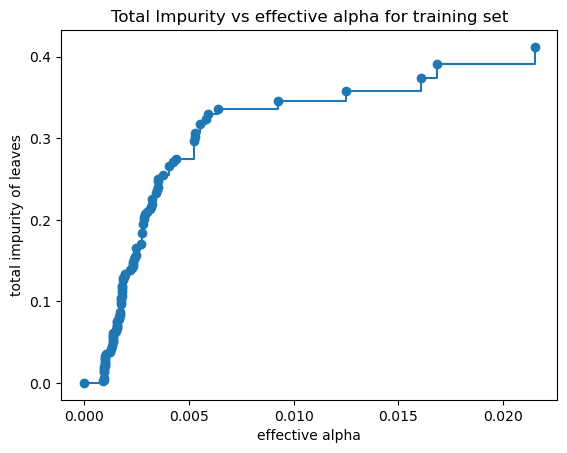

In [284]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas_wine[:-1], impurities_wine[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [285]:
clfs_wine = []
for ccp_alpha in ccp_alphas_wine:
    clf = DecisionTreeClassifier(random_state=12345, ccp_alpha=ccp_alpha)
    clf.fit(X_train_wine, y_train_wine)
    clfs_wine.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs_wine[-1].tree_.node_count, ccp_alphas_wine[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0836993010730886


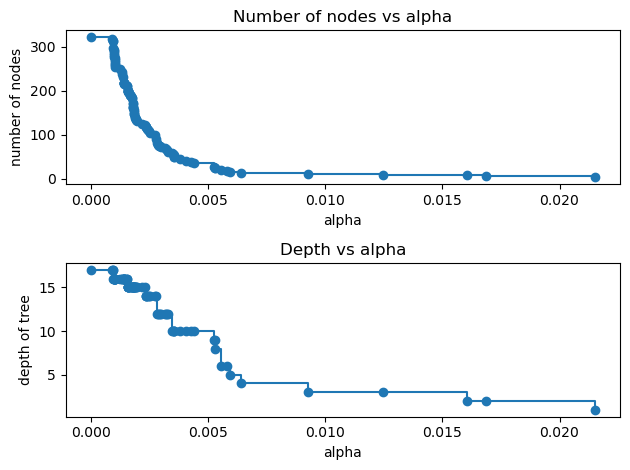

In [286]:
clfs_wine = clfs_wine[:-1]
ccp_alphas_wine = ccp_alphas_wine[:-1]

node_counts_wine = [clf.tree_.node_count for clf in clfs_wine]
depth_wine = [clf.tree_.max_depth for clf in clfs_wine]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas_wine, node_counts_wine, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas_wine, depth_wine, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

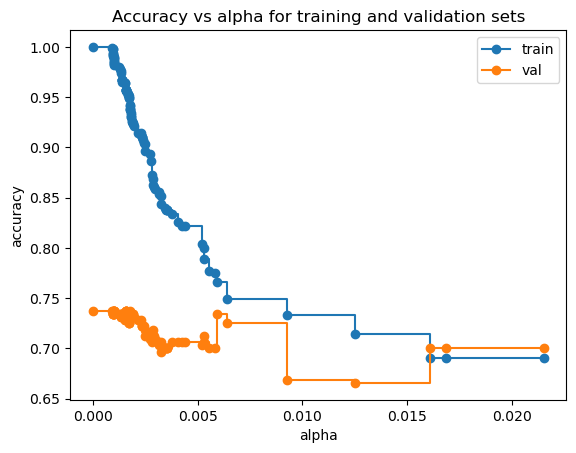

In [287]:
train_scores_wine = [clf.score(X_train_wine, y_train_wine) for clf in clfs_wine]
val_scores_wine = [clf.score(X_val_wine, y_val_wine) for clf in clfs_wine]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas_wine, train_scores_wine, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas_wine, val_scores_wine, marker="o", label="val", drawstyle="steps-post")
ax.legend()
plt.show()

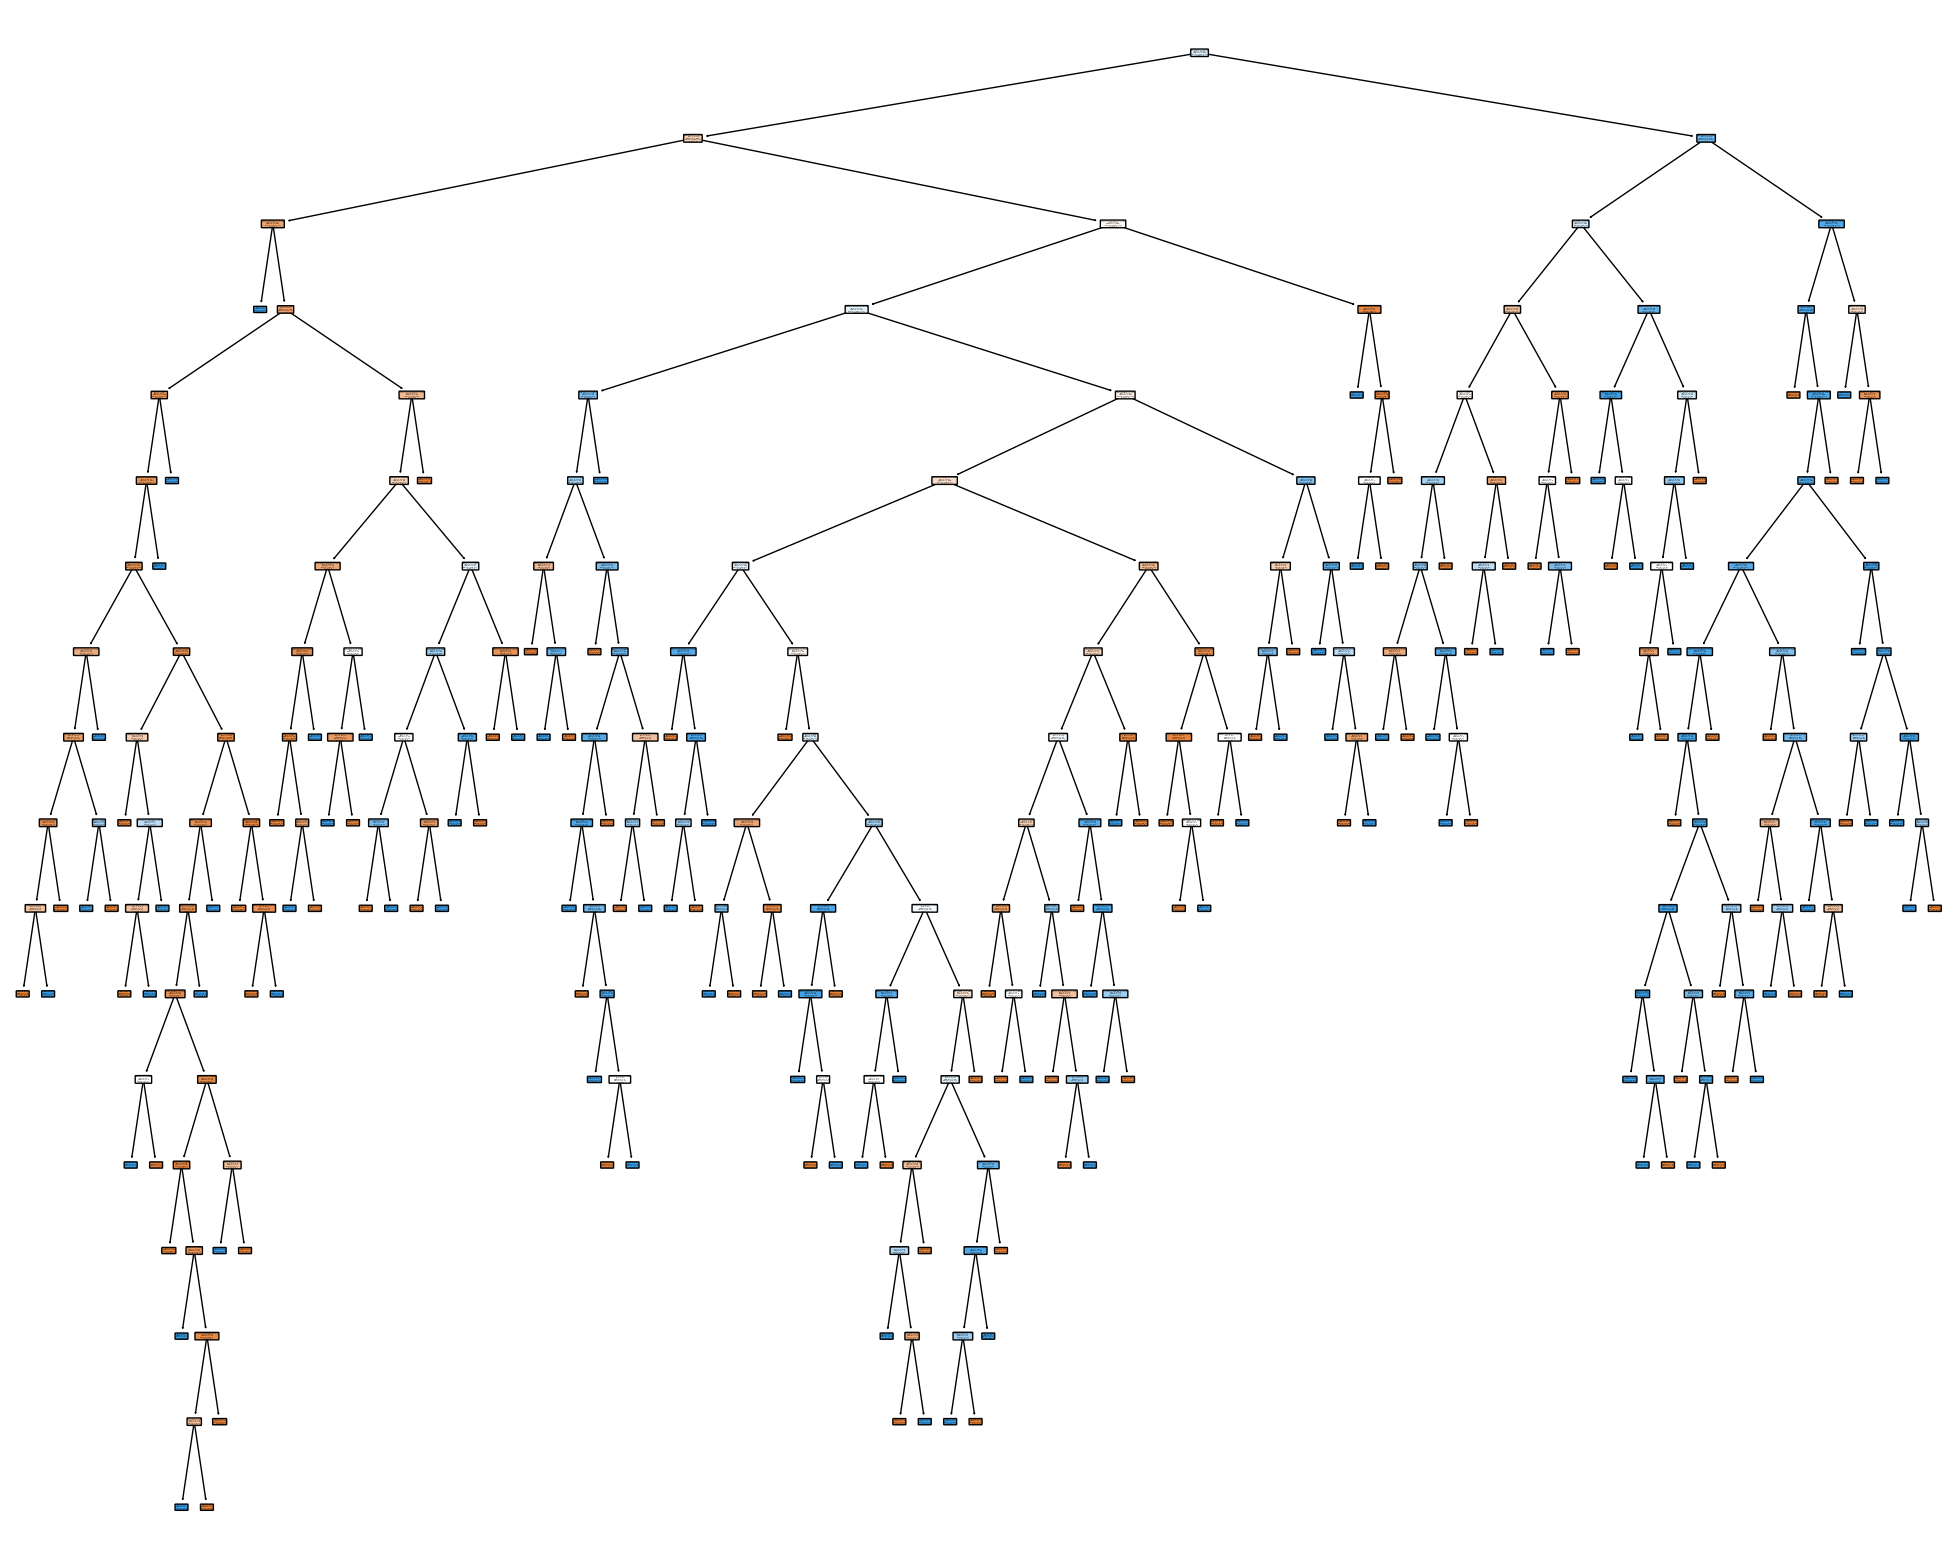

In [288]:
best_clf_wine = clfs_wine[np.argmax(val_scores_wine)]#베스트 스코어 가져오기

fig = plt.figure(figsize=(25,20))
_ = plot_tree(best_clf_wine,
                feature_names=features_wine.columns.values,
                class_names=list(map(str, target_wine.unique())),
                rounded=True,
                filled=True)


In [289]:
CART_post_prey_wine = best_clf_wine.predict(X_val_wine)
Perf_Table_Wine.loc['CART_Post_pruning_val'] = perf_eval(y_val_wine, CART_post_prey_wine)
CART_post_prey_wine = best_clf_wine.predict(X_test_wine)
Perf_Table_Wine.loc['CART_Post_pruning_test'] = perf_eval(y_test_wine, CART_post_prey_wine)

In [290]:
Perf_Table_Wine

TPR  Precision       TNR  Accuracy       BCR  \
CART_Post_pruning_val   0.769737   0.704819  0.708333  0.737500  0.738397   
CART_Post_pruning_test  0.737430   0.741573  0.673759  0.709375  0.704876   

                        F1-Measure     AUROC  
CART_Post_pruning_val     0.735849  0.739035  
CART_Post_pruning_test    0.739496  0.705595

### Prepruning

In [291]:
# Tree parameter settings
param_grid_wine = {'criterion': ['gini', 'entropy','log_loss'],
                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50],
                'min_samples_leaf': [i for i in range(1, 100, 10)],
                'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
model_wine = DecisionTreeClassifier(random_state=SEED)
grid_search_wine = GridSearchCV(model_wine, param_grid_wine, cv=5, scoring='roc_auc', n_jobs=-1, refit=True)

#5fold 방식을 사용하므로, train과 val을 합쳐서 train으로 사용
X_train_val_wine = pd.concat([X_train_wine, X_val_wine])
y_train_val_wine = pd.concat([y_train_wine, y_val_wine])

grid_search_wine.fit(X_train_val_wine, y_train_val_wine)

best_criterion_wine = grid_search_wine.best_params_['criterion']
best_max_depth_wine = grid_search_wine.best_params_['max_depth']
best_min_samples_split_wine = grid_search_wine.best_params_['min_samples_split']
best_min_samples_leaf_wine = grid_search_wine.best_params_['min_samples_leaf']
best_max_features_wine = grid_search_wine.best_params_['max_features']

print(f'best criterion: {best_criterion_wine}')
print(f'best max_depth: {best_max_depth_wine}')
print(f'best min_samples_split: {best_min_samples_split_wine}')
print(f'best min_samples_leaf: {best_min_samples_leaf_wine}')
print(f'best max_features: {best_max_features_wine}')

y_pred_wine = grid_search_wine.predict(X_val_wine)
Perf_Table_Wine.loc['CART_Pre_pruning_val'] = perf_eval(y_val_wine, y_pred_wine)
y_pred_wine = grid_search_wine.predict(X_test_wine)
Perf_Table_Wine.loc['CART_Pre_pruning_test'] = perf_eval(y_test_wine, y_pred_wine)

Perf_Table_Wine

best criterion: entropy
best max_depth: 8
best min_samples_split: 50
best min_samples_leaf: 21
best max_features: 7


TPR  Precision       TNR  Accuracy       BCR  \
CART_Post_pruning_val   0.769737   0.704819  0.708333  0.737500  0.738397   
CART_Post_pruning_test  0.737430   0.741573  0.673759  0.709375  0.704876   
CART_Pre_pruning_val    0.822368   0.796178  0.809524  0.815625  0.815921   
CART_Pre_pruning_test   0.743017   0.743017  0.673759  0.712500  0.707541   

                        F1-Measure     AUROC  
CART_Post_pruning_val     0.735849  0.739035  
CART_Post_pruning_test    0.739496  0.705595  
CART_Pre_pruning_val      0.809061  0.815946  
CART_Pre_pruning_test     0.743017  0.708388

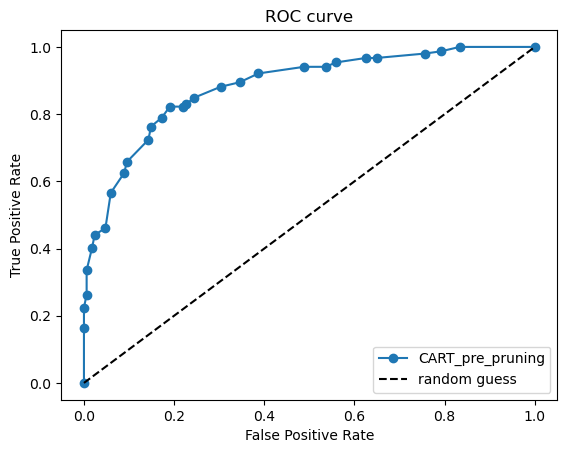

In [292]:
CART_pre_prob_wine = grid_search_wine.predict_proba(X_val_wine)[:,1]
fpr, tpr, thresholds = roc_curve(y_val_wine, CART_pre_prob_wine)
plt.plot(fpr, tpr, 'o-', label="CART_pre_pruning")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

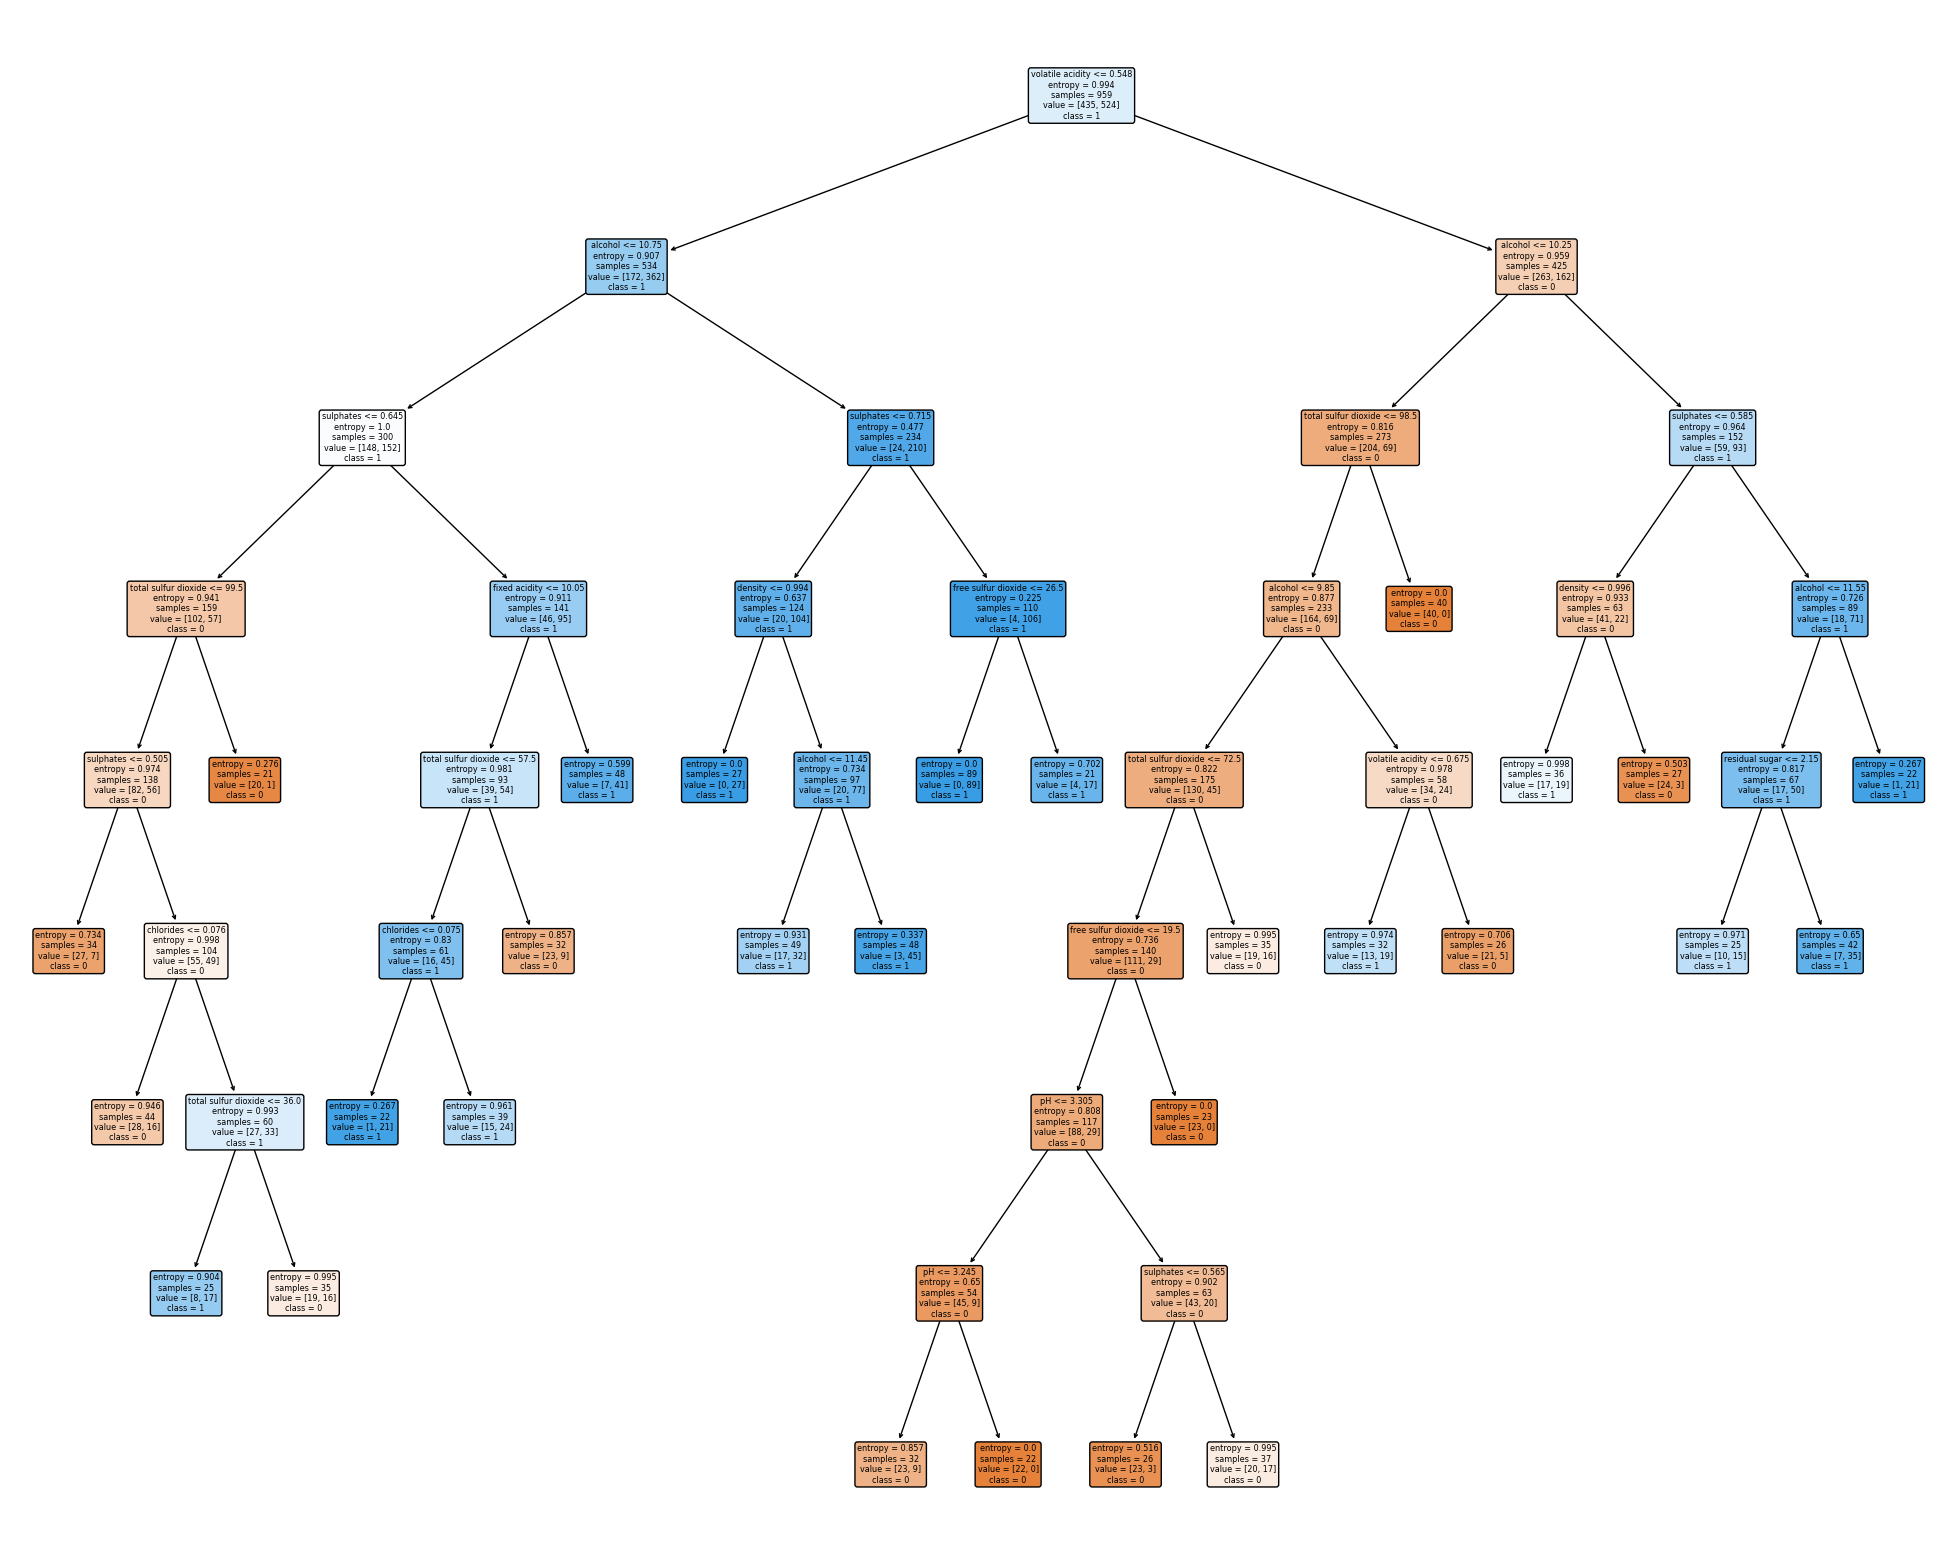

In [293]:
CART_pre_wine = DecisionTreeClassifier(**grid_search_wine.best_params_)
CART_pre_wine.fit(X_train_wine, y_train_wine)
plt.figure(figsize=(25,20))
_ = plot_tree(CART_pre_wine,
                feature_names=features_wine.columns.values,
                class_names=list(map(str, target_wine.unique())),
                rounded=True,
                filled=True)
plt.show()

## Neural Network

In [294]:
scaler = StandardScaler()
scaler.fit(X_train_wine)
X_train_scaled_wine = scaler.transform(X_train_wine)
X_val_scaled_wine = scaler.transform(X_val_wine)
X_test_scaled_wine = scaler.transform(X_test_wine)

#### Logistic Regression

In [295]:
ml_logit_wine = LogisticRegression(random_state=SEED, solver = 'newton-cg')
ml_logit_wine.fit(X_train_scaled_wine, y_train_wine)

LogisticRegression(random_state=42, solver='newton-cg')

In [296]:
print(ml_logit_wine.coef_)

[[ 0.36825296 -0.56087298 -0.14636946  0.098191   -0.11076807  0.20555757
  -0.56159756 -0.23227373  0.09499002  0.41366952  0.8731176 ]]


In [297]:
ml_logit_prey_wine = ml_logit_wine.predict(X_val_scaled_wine)
Perf_Table_Wine.loc['LogisticRegression_val'] = perf_eval(y_val_wine, ml_logit_prey_wine)
ml_logit_prey_wine = ml_logit_wine.predict(X_test_scaled_wine)
Perf_Table_Wine.loc['LogisticRegression_test'] = perf_eval(y_test_wine, ml_logit_prey_wine)

In [298]:
Perf_Table_Wine

TPR  Precision       TNR  Accuracy       BCR  \
CART_Post_pruning_val    0.769737   0.704819  0.708333  0.737500  0.738397   
CART_Post_pruning_test   0.737430   0.741573  0.673759  0.709375  0.704876   
CART_Pre_pruning_val     0.822368   0.796178  0.809524  0.815625  0.815921   
CART_Pre_pruning_test    0.743017   0.743017  0.673759  0.712500  0.707541   
LogisticRegression_val   0.750000   0.750000  0.773810  0.762500  0.761812   
LogisticRegression_test  0.743017   0.782353  0.737589  0.740625  0.740298   

                         F1-Measure     AUROC  
CART_Post_pruning_val      0.735849  0.739035  
CART_Post_pruning_test     0.739496  0.705595  
CART_Pre_pruning_val       0.809061  0.815946  
CART_Pre_pruning_test      0.743017  0.708388  
LogisticRegression_val     0.750000  0.761905  
LogisticRegression_test    0.762178  0.740303

#### NN

In [299]:
ann_trn_input_wine = X_train_scaled_wine
ann_trn_target_wine = y_train_wine
ann_val_input_wine = X_val_scaled_wine
ann_val_target_wine = y_val_wine
ann_tst_input_wine = X_test_scaled_wine
ann_tst_target_wine = y_test_wine

In [300]:
hyperparameters_wine = {
    'hidden_layer_sizes' : [(10,), (20,), (30,),(40,), (50,)
                            ,(10,10), (20,20), (30,30), (40,40), (50,50)
                            ,(10,10,10), (20,20,20), (30,30,30), (40,40,40), (50,50,50)],
    
    'activation_functions' : ['logistic', 'tanh', 'relu']
}

In [301]:
val_perf_wine = pd.DataFrame(columns = ["TPR", "Precision", "TNR", "Accuracy", "BCR", "F1-Measure", "AUROC"])

best_model_wine = None
for nh in hyperparameters_wine['hidden_layer_sizes']:
    for act in hyperparameters_wine['activation_functions']:
        print(f'hidden nodes: {nh}, activation function: {act}')
        
        tmp_nnet_wine = MLPClassifier(hidden_layer_sizes= nh, activation=act, max_iter=500, verbose=True)
        tmp_nnet_wine.fit(ann_trn_input_wine, ann_trn_target_wine)
        
        y_pred_wine = tmp_nnet_wine.predict(ann_val_input_wine)
        val_perf_wine.loc[f'hidden nodes: {nh}, activation function: {act}'] = perf_eval(ann_val_target_wine, y_pred_wine)
        if best_model_wine is None:
            best_model_wine = tmp_nnet_wine
        elif roc_auc_score(ann_val_target_wine, y_pred_wine) > roc_auc_score(ann_val_target_wine, best_model_wine.predict(ann_val_input_wine)):
            best_model_wine = tmp_nnet_wine
            
val_perf_wine

hidden nodes: (10,), activation function: logistic
Iteration 1, loss = 0.68413332
Iteration 2, loss = 0.68116555
Iteration 3, loss = 0.67820129
Iteration 4, loss = 0.67512275
Iteration 5, loss = 0.67228020
Iteration 6, loss = 0.66942828
Iteration 7, loss = 0.66679632
Iteration 8, loss = 0.66394764
Iteration 9, loss = 0.66128663
Iteration 10, loss = 0.65856039
Iteration 11, loss = 0.65593139
Iteration 12, loss = 0.65327961
Iteration 13, loss = 0.65063079
Iteration 14, loss = 0.64792141
Iteration 15, loss = 0.64537379
Iteration 16, loss = 0.64278532
Iteration 17, loss = 0.64014118
Iteration 18, loss = 0.63758313
Iteration 19, loss = 0.63508226
Iteration 20, loss = 0.63246222
Iteration 21, loss = 0.62987952
Iteration 22, loss = 0.62743448
Iteration 23, loss = 0.62485640
Iteration 24, loss = 0.62235086
Iteration 25, loss = 0.61980010
Iteration 26, loss = 0.61737449
Iteration 27, loss = 0.61483476
Iteration 28, loss = 0.61245583
Iteration 29, loss = 0.60995757
Iteration 30, loss = 0.6075595

TPR  Precision  \
hidden nodes: (10,), activation function: logistic  0.756579   0.761589   
hidden nodes: (10,), activation function: tanh      0.723684   0.738255   
hidden nodes: (10,), activation function: relu      0.736842   0.777778   
hidden nodes: (20,), activation function: logistic  0.723684   0.738255   
hidden nodes: (20,), activation function: tanh      0.730263   0.755102   
hidden nodes: (20,), activation function: relu      0.723684   0.769231   
hidden nodes: (30,), activation function: logistic  0.743421   0.743421   
hidden nodes: (30,), activation function: tanh      0.769737   0.769737   
hidden nodes: (30,), activation function: relu      0.736842   0.746667   
hidden nodes: (40,), activation function: logistic  0.763158   0.753247   
hidden nodes: (40,), activation function: tanh      0.750000   0.750000   
hidden nodes: (40,), activation function: relu      0.717105   0.767606   
hidden nodes: (50,), activation function: logistic  0.756579   0.746753   
hidden nodes: (50,), activation function: tanh      0.763158   0.738854   
hidden nodes: (50,), activation function: relu      0.743421   0.758389   
hidden nodes: (10, 10), activation function: lo...  0.717105   0.746575   
hidden nodes: (10, 10), activation function: tanh   0.776316   0.732919   
hidden nodes: (10, 10), activation function: relu   0.730263   0.730263   
hidden nodes: (20, 20), activation function: lo...  0.750000   0.770270   
hidden nodes: (20, 20), activation function: tanh   0.776316   0.715152   
hidden nodes: (20, 20), activation function: relu   0.763158   0.738854   
hidden nodes: (30, 30), activation function: lo...  0.743421   0.773973   
hidden nodes: (30, 30), activation function: tanh   0.789474   0.754717   
hidden nodes: (30, 30), activation function: relu   0.776316   0.746835   
hidden nodes: (40, 40), activation function: lo...  0.743421   0.743421   
hidden nodes: (40, 40), activation function: tanh   0.756579   0.732484   
hidden nodes: (40, 40), activation function: relu   0.776316   0.728395   
hidden nodes: (50, 50), activation function: lo...  0.750000   0.780822   
hidden nodes: (50, 50), activation function: tanh   0.743421   0.729032   
hidden nodes: (50, 50), activation function: relu   0.776316   0.690058   
hidden nodes: (10, 10, 10), activation function...  0.736842   0.761905   
hidden nodes: (10, 10, 10), activation function...  0.743421   0.684848   
hidden nodes: (10, 10, 10), activation function...  0.769737   0.740506   
hidden nodes: (20, 20, 20), activation function...  0.750000   0.770270   
hidden nodes: (20, 20, 20), activation function...  0.756579   0.668605   
hidden nodes: (20, 20, 20), activation function...  0.809211   0.706897   
hidden nodes: (30, 30, 30), activation function...  0.723684   0.769231   
hidden nodes: (30, 30, 30), activation function...  0.809211   0.675824   
hidden nodes: (30, 30, 30), activation function...  0.756579   0.718750   
hidden nodes: (40, 40, 40), activation function...  0.750000   0.760000   
hidden nodes: (40, 40, 40), activation function...  0.743421   0.693252   
hidden nodes: (40, 40, 40), activation function...  0.789474   0.689655   
hidden nodes: (50, 50, 50), activation function...  0.750000   0.735484   
hidden nodes: (50, 50, 50), activation function...  0.756579   0.723270   
hidden nodes: (50, 50, 50), activation function...  0.789474   0.722892   

                                                         TNR  Accuracy  \
hidden nodes: (10,), activation function: logistic  0.785714  0.771875   
hidden nodes: (10,), activation function: tanh      0.767857  0.746875   
hidden nodes: (10,), activation function: relu      0.809524  0.775000   
hidden nodes: (20,), activation function: logistic  0.767857  0.746875   
hidden nodes: (20,), activation function: tanh      0.785714  0.759375   
hidden nodes: (20,), activation function: relu      0.803571  0.765625   
hidden nodes: (30,), activation function: logistic  0.767857  0.756250   
hidden nodes: 

In [302]:
ordered_val_perf_wine = val_perf_wine.sort_values(by='AUROC', ascending=False)
ordered_val_perf_wine

TPR  Precision  \
hidden nodes: (30,), activation function: tanh      0.769737   0.769737   
hidden nodes: (50, 50), activation function: lo...  0.750000   0.780822   
hidden nodes: (30, 30), activation function: tanh   0.789474   0.754717   
hidden nodes: (20, 20, 20), activation function...  0.750000   0.770270   
hidden nodes: (20, 20), activation function: lo...  0.750000   0.770270   
hidden nodes: (30, 30), activation function: lo...  0.743421   0.773973   
hidden nodes: (10,), activation function: relu      0.736842   0.777778   
hidden nodes: (10,), activation function: logistic  0.756579   0.761589   
hidden nodes: (30, 30), activation function: relu   0.776316   0.746835   
hidden nodes: (40,), activation function: logistic  0.763158   0.753247   
hidden nodes: (40, 40, 40), activation function...  0.750000   0.760000   
hidden nodes: (50,), activation function: relu      0.743421   0.758389   
hidden nodes: (10, 10, 10), activation function...  0.736842   0.761905   
hidden nodes: (30, 30, 30), activation function...  0.723684   0.769231   
hidden nodes: (20,), activation function: relu      0.723684   0.769231   
hidden nodes: (10, 10, 10), activation function...  0.769737   0.740506   
hidden nodes: (50,), activation function: logistic  0.756579   0.746753   
hidden nodes: (40,), activation function: tanh      0.750000   0.750000   
hidden nodes: (40,), activation function: relu      0.717105   0.767606   
hidden nodes: (10, 10), activation function: tanh   0.776316   0.732919   
hidden nodes: (50,), activation function: tanh      0.763158   0.738854   
hidden nodes: (20, 20), activation function: relu   0.763158   0.738854   
hidden nodes: (20,), activation function: tanh      0.730263   0.755102   
hidden nodes: (50, 50, 50), activation function...  0.789474   0.722892   
hidden nodes: (40, 40), activation function: relu   0.776316   0.728395   
hidden nodes: (30,), activation function: logistic  0.743421   0.743421   
hidden nodes: (40, 40), activation function: lo...  0.743421   0.743421   
hidden nodes: (30,), activation function: relu      0.736842   0.746667   
hidden nodes: (40, 40), activation function: tanh   0.756579   0.732484   
hidden nodes: (50, 50, 50), activation function...  0.750000   0.735484   
hidden nodes: (20, 20, 20), activation function...  0.809211   0.706897   
hidden nodes: (10, 10), activation function: lo...  0.717105   0.746575   
hidden nodes: (20, 20), activation function: tanh   0.776316   0.715152   
hidden nodes: (50, 50, 50), activation function...  0.756579   0.723270   
hidden nodes: (50, 50), activation function: tanh   0.743421   0.729032   
hidden nodes: (20,), activation function: logistic  0.723684   0.738255   
hidden nodes: (10,), activation function: tanh      0.723684   0.738255   
hidden nodes: (30, 30, 30), activation function...  0.756579   0.718750   
hidden nodes: (10, 10), activation function: relu   0.730263   0.730263   
hidden nodes: (40, 40, 40), activation function...  0.789474   0.689655   
hidden nodes: (50, 50), activation function: relu   0.776316   0.690058   
hidden nodes: (30, 30, 30), activation function...  0.809211   0.675824   
hidden nodes: (40, 40, 40), activation function...  0.743421   0.693252   
hidden nodes: (10, 10, 10), activation function...  0.743421   0.684848   
hidden nodes: (20, 20, 20), activation function...  0.756579   0.668605   

                                                         TNR  Accuracy  \
hidden nodes: (30,), activation function: tanh      0.791667  0.781250   
hidden nodes: (50, 50), activation function: lo...  0.809524  0.781250   
hidden nodes: (30, 30), activation function: tanh   0.767857  0.778125   
hidden nodes: (20, 20, 20), activation function...  0.797619  0.775000   
hidden nodes: (20, 20), activation function: lo...  0.797619  0.775000   
hidden nodes: (30, 30), activation function: lo...  0.803571  0.775000   
hidden nodes: (10,), activation function: relu      0.809524  0.775000   
hidden nodes: 

In [303]:
hidden_act_wine = pd.DataFrame(np.array(val_perf_wine.iloc[:, 6]).reshape(15,3), columns = ['logistic', 'tanh', 'relu'], index =
                [(10,), (20,), (30,),(40,), (50,),
                (10,10), (20,20), (30,30), (40,40), (50,50),
                (10,10,10), (20,20,20), (30,30,30), (40,40,40), (50,50,50)])

hidden_act_wine

logistic      tanh      relu
(10,)         0.771147  0.745771  0.773183
(20,)         0.745771  0.757989  0.763628
(30,)         0.755639  0.780702  0.755326
(40,)         0.768484  0.761905  0.760338
(50,)         0.762218  0.759555  0.764568
(10, 10)      0.748434  0.760182  0.743108
(20, 20)      0.773810  0.748277  0.759555
(30, 30)      0.773496  0.778665  0.769110
(40, 40)      0.755639  0.753289  0.757206
(50, 50)      0.779762  0.746711  0.730420
(10, 10, 10)  0.764254  0.716949  0.762845
(20, 20, 20)  0.773810  0.708647  0.752820
(30, 30, 30)  0.763628  0.729010  0.744361
(40, 40, 40)  0.767857  0.722901  0.734023
(50, 50, 50)  0.752976  0.747337  0.757832

In [304]:
best_model_wine

MLPClassifier(activation='tanh', hidden_layer_sizes=(30,), max_iter=500,
              verbose=True)

In [305]:
# Best model
y_pred_wine = best_model_wine.predict(ann_val_input_wine)
Perf_Table_Wine.loc['NN_val'] = perf_eval(ann_val_target_wine, y_pred_wine)
y_pred_wine = best_model_wine.predict(ann_tst_input_wine)
Perf_Table_Wine.loc['NN_test'] = perf_eval(ann_tst_target_wine, y_pred_wine)

In [306]:
Perf_Table_Wine

TPR  Precision       TNR  Accuracy       BCR  \
CART_Post_pruning_val    0.769737   0.704819  0.708333  0.737500  0.738397   
CART_Post_pruning_test   0.737430   0.741573  0.673759  0.709375  0.704876   
CART_Pre_pruning_val     0.822368   0.796178  0.809524  0.815625  0.815921   
CART_Pre_pruning_test    0.743017   0.743017  0.673759  0.712500  0.707541   
LogisticRegression_val   0.750000   0.750000  0.773810  0.762500  0.761812   
LogisticRegression_test  0.743017   0.782353  0.737589  0.740625  0.740298   
NN_val                   0.769737   0.769737  0.791667  0.781250  0.780625   
NN_test                  0.782123   0.795455  0.744681  0.765625  0.763172   

                         F1-Measure     AUROC  
CART_Post_pruning_val      0.735849  0.739035  
CART_Post_pruning_test     0.739496  0.705595  
CART_Pre_pruning_val       0.809061  0.815946  
CART_Pre_pruning_test      0.743017  0.708388  
LogisticRegression_val     0.750000  0.761905  
LogisticRegression_test    0.762178  0.740303  
NN_val                     0.769737  0.780702  
NN_test                    0.788732  0.763402

In [307]:
Perf_Table_Wine_Test = round_dataframe(Perf_Table_Wine.iloc[[1,3,5,7]])
Perf_Table_Wine_Test

TPR  Precision     TNR  Accuracy     BCR  \
CART_Post_pruning_test   0.7374     0.7416  0.6738    0.7094  0.7049   
CART_Pre_pruning_test    0.7430     0.7430  0.6738    0.7125  0.7075   
LogisticRegression_test  0.7430     0.7824  0.7376    0.7406  0.7403   
NN_test                  0.7821     0.7955  0.7447    0.7656  0.7632   

                         F1-Measure   AUROC  
CART_Post_pruning_test       0.7395  0.7056  
CART_Pre_pruning_test        0.7430  0.7084  
LogisticRegression_test      0.7622  0.7403  
NN_test                      0.7887  0.7634